In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(369744, 828)
(369744, 1)
validation
(50536, 828)
(50536, 1)
test
(51136, 828)
(51136, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 46s - loss: 0.3811 - STD: 7.3039e-05 - MAE: 0.6103

 4/37 [==>...........................] - ETA: 0s - loss: 0.1549 - STD: 4.6164e-04 - MAE: 0.3283 

 5/37 [===>..........................] - ETA: 1s - loss: 0.1259 - STD: 4.1380e-04 - MAE: 0.2775

 6/37 [===>..........................] - ETA: 1s - loss: 0.1075 - STD: 3.6308e-04 - MAE: 0.2470

 7/37 [====>.........................] - ETA: 1s - loss: 0.0951 - STD: 3.1924e-04 - MAE: 0.2277

 8/37 [=====>........................] - ETA: 1s - loss: 0.0862 - STD: 2.8296e-04 - MAE: 0.2150

 9/37 [======>.......................] - ETA: 1s - loss: 0.0796 - STD: 2.5329e-04 - MAE: 0.2060

10/37 [=======>......................] - ETA: 1s - loss: 0.0744 - STD: 2.2879e-04 - MAE: 0.1994

11/37 [=======>......................] - ETA: 1s - loss: 0.0703 - STD: 2.0828e-04 - MAE: 0.1944

12/37 [========>.....................] - ETA: 1s - loss: 0.0670 - STD: 1.9117e-04 - MAE: 0.1905

13/37 [=========>....................] - ETA: 1s - loss: 0.0641 - STD: 1.7681e-04 - MAE: 0.1870

14/37 [==========>...................] - ETA: 1s - loss: 0.0617 - STD: 1.6463e-04 - MAE: 0.1842

15/37 [===========>..................] - ETA: 1s - loss: 0.0596 - STD: 1.5418e-04 - MAE: 0.1818

16/37 [===========>..................] - ETA: 1s - loss: 0.0578 - STD: 1.4500e-04 - MAE: 0.1796

17/37 [============>.................] - ETA: 1s - loss: 0.0561 - STD: 1.3693e-04 - MAE: 0.1775

18/37 [=============>................] - ETA: 1s - loss: 0.0546 - STD: 1.2978e-04 - MAE: 0.1757

19/37 [==============>...............] - ETA: 1s - loss: 0.0532 - STD: 1.2338e-04 - MAE: 0.1739

20/37 [===============>..............] - ETA: 0s - loss: 0.0519 - STD: 1.1766e-04 - MAE: 0.1721

21/37 [================>.............] - ETA: 0s - loss: 0.0507 - STD: 1.1243e-04 - MAE: 0.1704

22/37 [================>.............] - ETA: 0s - loss: 0.0496 - STD: 1.0773e-04 - MAE: 0.1686

23/37 [=================>............] - ETA: 0s - loss: 0.0485 - STD: 1.0341e-04 - MAE: 0.1668

24/37 [==================>...........] - ETA: 0s - loss: 0.0474 - STD: 9.9468e-05 - MAE: 0.1649

25/37 [===================>..........] - ETA: 0s - loss: 0.0464 - STD: 9.5869e-05 - MAE: 0.1630

26/37 [====================>.........] - ETA: 0s - loss: 0.0453 - STD: 9.2558e-05 - MAE: 0.1609

27/37 [====================>.........] - ETA: 0s - loss: 0.0443 - STD: 8.9457e-05 - MAE: 0.1588

28/37 [=====================>........] - ETA: 0s - loss: 0.0434 - STD: 8.6672e-05 - MAE: 0.1566

31/37 [========================>.....] - ETA: 0s - loss: 0.0404 - STD: 7.9526e-05 - MAE: 0.1496

33/37 [=========================>....] - ETA: 0s - loss: 0.0386 - STD: 7.5527e-05 - MAE: 0.1450

34/37 [==========================>...] - ETA: 0s - loss: 0.0377 - STD: 7.3772e-05 - MAE: 0.1429

35/37 [===========================>..] - ETA: 0s - loss: 0.0369 - STD: 7.2037e-05 - MAE: 0.1409

36/37 [============================>.] - ETA: 0s - loss: 0.0361 - STD: 7.0442e-05 - MAE: 0.1391

37/37 [==============================] - ETA: 0s - loss: 0.0354 - STD: 6.8904e-05 - MAE: 0.1376

37/37 [==============================] - 5s 92ms/step - loss: 0.0354 - STD: 6.8904e-05 - MAE: 0.1376 - val_loss: 0.0102 - val_STD: 1.0842e-05 - val_MAE: 0.0772


Epoch 2/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0102 - STD: 1.2970e-05 - MAE: 0.0848

 2/37 [>.............................] - ETA: 2s - loss: 0.0105 - STD: 1.2748e-05 - MAE: 0.0864

 3/37 [=>............................] - ETA: 2s - loss: 0.0107 - STD: 1.2617e-05 - MAE: 0.0873

 4/37 [==>...........................] - ETA: 2s - loss: 0.0108 - STD: 1.2365e-05 - MAE: 0.0878

 5/37 [===>..........................] - ETA: 2s - loss: 0.0108 - STD: 1.1924e-05 - MAE: 0.0879

 6/37 [===>..........................] - ETA: 2s - loss: 0.0107 - STD: 1.2197e-05 - MAE: 0.0875

 7/37 [====>.........................] - ETA: 2s - loss: 0.0106 - STD: 1.2131e-05 - MAE: 0.0869

 8/37 [=====>........................] - ETA: 1s - loss: 0.0104 - STD: 1.1487e-05 - MAE: 0.0861

 9/37 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 1.1058e-05 - MAE: 0.0851

10/37 [=======>......................] - ETA: 1s - loss: 0.0101 - STD: 1.0718e-05 - MAE: 0.0840

11/37 [=======>......................] - ETA: 1s - loss: 0.0100 - STD: 1.0446e-05 - MAE: 0.0832

12/37 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 1.0080e-05 - MAE: 0.0824

13/37 [=========>....................] - ETA: 1s - loss: 0.0098 - STD: 9.8710e-06 - MAE: 0.0816

14/37 [==========>...................] - ETA: 1s - loss: 0.0097 - STD: 9.5887e-06 - MAE: 0.0809

15/37 [===========>..................] - ETA: 1s - loss: 0.0097 - STD: 9.4124e-06 - MAE: 0.0804

16/37 [===========>..................] - ETA: 1s - loss: 0.0096 - STD: 9.1369e-06 - MAE: 0.0799

17/37 [============>.................] - ETA: 1s - loss: 0.0096 - STD: 9.0105e-06 - MAE: 0.0795

18/37 [=============>................] - ETA: 1s - loss: 0.0096 - STD: 8.7639e-06 - MAE: 0.0790

19/37 [==============>...............] - ETA: 1s - loss: 0.0096 - STD: 8.4905e-06 - MAE: 0.0787

20/37 [===============>..............] - ETA: 1s - loss: 0.0096 - STD: 8.3787e-06 - MAE: 0.0785

21/37 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 8.2933e-06 - MAE: 0.0782

22/37 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 8.1167e-06 - MAE: 0.0779

23/37 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 8.0319e-06 - MAE: 0.0777

24/37 [==================>...........] - ETA: 0s - loss: 0.0094 - STD: 7.9942e-06 - MAE: 0.0774

25/37 [===================>..........] - ETA: 0s - loss: 0.0094 - STD: 7.8842e-06 - MAE: 0.0772

26/37 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 7.8519e-06 - MAE: 0.0771

27/37 [====================>.........] - ETA: 0s - loss: 0.0093 - STD: 7.7553e-06 - MAE: 0.0769

28/37 [=====================>........] - ETA: 0s - loss: 0.0093 - STD: 7.6792e-06 - MAE: 0.0768

29/37 [======================>.......] - ETA: 0s - loss: 0.0093 - STD: 7.6727e-06 - MAE: 0.0767

30/37 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 7.6398e-06 - MAE: 0.0767

31/37 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 7.6061e-06 - MAE: 0.0766

32/37 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.5339e-06 - MAE: 0.0766

33/37 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 7.5222e-06 - MAE: 0.0766

34/37 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.5185e-06 - MAE: 0.0765

35/37 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 7.5318e-06 - MAE: 0.0765

36/37 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 7.4982e-06 - MAE: 0.0765

37/37 [==============================] - ETA: 0s - loss: 0.0092 - STD: 7.4432e-06 - MAE: 0.0764

37/37 [==============================] - 3s 71ms/step - loss: 0.0092 - STD: 7.4432e-06 - MAE: 0.0764 - val_loss: 0.0087 - val_STD: 4.3052e-06 - val_MAE: 0.0689


Epoch 3/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0085 - STD: 5.2031e-06 - MAE: 0.0736

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 5.5943e-06 - MAE: 0.0738

 3/37 [=>............................] - ETA: 2s - loss: 0.0087 - STD: 5.9544e-06 - MAE: 0.0740

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 5.8108e-06 - MAE: 0.0737

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 5.4219e-06 - MAE: 0.0734

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 5.5049e-06 - MAE: 0.0733

 7/37 [====>.........................] - ETA: 2s - loss: 0.0086 - STD: 5.3260e-06 - MAE: 0.0732

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 5.2954e-06 - MAE: 0.0732

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 5.3104e-06 - MAE: 0.0731

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 5.2726e-06 - MAE: 0.0731

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 5.2723e-06 - MAE: 0.0731

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 5.1772e-06 - MAE: 0.0731

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 5.2194e-06 - MAE: 0.0731

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 5.2948e-06 - MAE: 0.0731

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 5.1599e-06 - MAE: 0.0731

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 5.0947e-06 - MAE: 0.0731

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 5.0100e-06 - MAE: 0.0731

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 5.0469e-06 - MAE: 0.0732

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 5.0249e-06 - MAE: 0.0732

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 5.0315e-06 - MAE: 0.0732

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 5.1352e-06 - MAE: 0.0732

22/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 5.2044e-06 - MAE: 0.0733

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 5.2314e-06 - MAE: 0.0733

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 5.2784e-06 - MAE: 0.0733

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 5.3296e-06 - MAE: 0.0733

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.3092e-06 - MAE: 0.0734

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.3616e-06 - MAE: 0.0733

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 5.3600e-06 - MAE: 0.0734

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 5.3422e-06 - MAE: 0.0734

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 5.2974e-06 - MAE: 0.0734

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 5.2842e-06 - MAE: 0.0734

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 5.2856e-06 - MAE: 0.0734

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 5.2806e-06 - MAE: 0.0734

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 5.2501e-06 - MAE: 0.0734

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 5.2413e-06 - MAE: 0.0734

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 5.2397e-06 - MAE: 0.0734

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 5.2190e-06 - MAE: 0.0734

37/37 [==============================] - 3s 71ms/step - loss: 0.0086 - STD: 5.2190e-06 - MAE: 0.0734 - val_loss: 0.0087 - val_STD: 3.7333e-06 - val_MAE: 0.0685


Epoch 4/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0086 - STD: 4.4657e-06 - MAE: 0.0734

 2/37 [>.............................] - ETA: 2s - loss: 0.0087 - STD: 4.7370e-06 - MAE: 0.0735

 3/37 [=>............................] - ETA: 2s - loss: 0.0087 - STD: 4.6915e-06 - MAE: 0.0736

 4/37 [==>...........................] - ETA: 2s - loss: 0.0087 - STD: 4.6541e-06 - MAE: 0.0736

 5/37 [===>..........................] - ETA: 2s - loss: 0.0087 - STD: 4.6798e-06 - MAE: 0.0736

 6/37 [===>..........................] - ETA: 2s - loss: 0.0087 - STD: 4.7222e-06 - MAE: 0.0737

 7/37 [====>.........................] - ETA: 2s - loss: 0.0086 - STD: 4.7458e-06 - MAE: 0.0735

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 4.7679e-06 - MAE: 0.0735

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 4.7753e-06 - MAE: 0.0734

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 4.7816e-06 - MAE: 0.0736

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 4.7693e-06 - MAE: 0.0735

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 4.7779e-06 - MAE: 0.0736

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 4.8647e-06 - MAE: 0.0736

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 4.8800e-06 - MAE: 0.0736

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 4.8777e-06 - MAE: 0.0736

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 4.9241e-06 - MAE: 0.0735

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 5.0081e-06 - MAE: 0.0735

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 5.0550e-06 - MAE: 0.0735

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 5.0815e-06 - MAE: 0.0735

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 5.1206e-06 - MAE: 0.0735

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 5.1750e-06 - MAE: 0.0735

22/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 5.2240e-06 - MAE: 0.0735

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 5.2482e-06 - MAE: 0.0736

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 5.2574e-06 - MAE: 0.0735

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 5.2877e-06 - MAE: 0.0735

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.2625e-06 - MAE: 0.0735

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.2364e-06 - MAE: 0.0735

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 5.2331e-06 - MAE: 0.0735

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 5.2026e-06 - MAE: 0.0736

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 5.1546e-06 - MAE: 0.0735

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 5.1119e-06 - MAE: 0.0735

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 5.0844e-06 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 5.0895e-06 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 5.1031e-06 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 5.1484e-06 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 5.1791e-06 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 5.1744e-06 - MAE: 0.0735

37/37 [==============================] - 3s 72ms/step - loss: 0.0086 - STD: 5.1744e-06 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 4.1059e-06 - val_MAE: 0.0685


Epoch 5/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0084 - STD: 4.6913e-06 - MAE: 0.0724

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 4.7037e-06 - MAE: 0.0731

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 4.6627e-06 - MAE: 0.0733

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 4.8787e-06 - MAE: 0.0734

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 5.2090e-06 - MAE: 0.0734

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 5.4046e-06 - MAE: 0.0733

 7/37 [====>.........................] - ETA: 1s - loss: 0.0086 - STD: 5.4208e-06 - MAE: 0.0734

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 5.3440e-06 - MAE: 0.0734

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 5.3445e-06 - MAE: 0.0733

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 5.3553e-06 - MAE: 0.0733

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 5.2711e-06 - MAE: 0.0733

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 5.2131e-06 - MAE: 0.0733

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 5.2737e-06 - MAE: 0.0733

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 5.3403e-06 - MAE: 0.0733

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 5.3705e-06 - MAE: 0.0734

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 5.3985e-06 - MAE: 0.0734

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 5.4191e-06 - MAE: 0.0734

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 5.4391e-06 - MAE: 0.0735

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 5.4627e-06 - MAE: 0.0735

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 5.4930e-06 - MAE: 0.0735

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 5.4789e-06 - MAE: 0.0735

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 5.4762e-06 - MAE: 0.0735

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 5.4837e-06 - MAE: 0.0735

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 5.4684e-06 - MAE: 0.0734

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 5.3868e-06 - MAE: 0.0734

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.3512e-06 - MAE: 0.0734

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.3203e-06 - MAE: 0.0734

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 5.2975e-06 - MAE: 0.0734

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 5.2737e-06 - MAE: 0.0734

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 5.2422e-06 - MAE: 0.0734

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 5.1860e-06 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 5.1880e-06 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 5.1872e-06 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 5.1951e-06 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 5.1992e-06 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 5.2031e-06 - MAE: 0.0735

37/37 [==============================] - 3s 70ms/step - loss: 0.0086 - STD: 5.2031e-06 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 3.8838e-06 - val_MAE: 0.0686


Epoch 6/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0087 - STD: 5.1680e-06 - MAE: 0.0737

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 5.0162e-06 - MAE: 0.0735

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 4.8016e-06 - MAE: 0.0734

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 4.9108e-06 - MAE: 0.0736

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 5.0908e-06 - MAE: 0.0736

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 5.3368e-06 - MAE: 0.0736

 7/37 [====>.........................] - ETA: 2s - loss: 0.0087 - STD: 5.4473e-06 - MAE: 0.0738

 8/37 [=====>........................] - ETA: 1s - loss: 0.0087 - STD: 5.6566e-06 - MAE: 0.0739

 9/37 [======>.......................] - ETA: 1s - loss: 0.0087 - STD: 5.6783e-06 - MAE: 0.0738

10/37 [=======>......................] - ETA: 1s - loss: 0.0087 - STD: 5.5847e-06 - MAE: 0.0740

11/37 [=======>......................] - ETA: 1s - loss: 0.0087 - STD: 5.5149e-06 - MAE: 0.0739

12/37 [========>.....................] - ETA: 1s - loss: 0.0087 - STD: 5.5591e-06 - MAE: 0.0739

13/37 [=========>....................] - ETA: 1s - loss: 0.0087 - STD: 5.6152e-06 - MAE: 0.0739

14/37 [==========>...................] - ETA: 1s - loss: 0.0087 - STD: 5.6365e-06 - MAE: 0.0738

15/37 [===========>..................] - ETA: 1s - loss: 0.0087 - STD: 5.7684e-06 - MAE: 0.0739

16/37 [===========>..................] - ETA: 1s - loss: 0.0087 - STD: 5.8445e-06 - MAE: 0.0738

17/37 [============>.................] - ETA: 1s - loss: 0.0087 - STD: 5.9233e-06 - MAE: 0.0739

18/37 [=============>................] - ETA: 1s - loss: 0.0087 - STD: 6.0156e-06 - MAE: 0.0739

19/37 [==============>...............] - ETA: 1s - loss: 0.0087 - STD: 6.0847e-06 - MAE: 0.0739

20/37 [===============>..............] - ETA: 1s - loss: 0.0087 - STD: 6.1555e-06 - MAE: 0.0738

21/37 [================>.............] - ETA: 1s - loss: 0.0087 - STD: 6.1763e-06 - MAE: 0.0738

22/37 [================>.............] - ETA: 0s - loss: 0.0087 - STD: 6.1982e-06 - MAE: 0.0738

23/37 [=================>............] - ETA: 0s - loss: 0.0087 - STD: 6.2589e-06 - MAE: 0.0737

24/37 [==================>...........] - ETA: 0s - loss: 0.0087 - STD: 6.3665e-06 - MAE: 0.0737

25/37 [===================>..........] - ETA: 0s - loss: 0.0087 - STD: 6.3951e-06 - MAE: 0.0737

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 6.3649e-06 - MAE: 0.0736

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 6.3683e-06 - MAE: 0.0736

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 6.3804e-06 - MAE: 0.0736

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 6.3838e-06 - MAE: 0.0736

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 6.3963e-06 - MAE: 0.0735

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 6.3842e-06 - MAE: 0.0735

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 6.4512e-06 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 6.4999e-06 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 6.5306e-06 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 6.5821e-06 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 6.5456e-06 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 6.5446e-06 - MAE: 0.0735

37/37 [==============================] - 3s 71ms/step - loss: 0.0086 - STD: 6.5446e-06 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 5.9412e-06 - val_MAE: 0.0686


Epoch 7/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0086 - STD: 7.3938e-06 - MAE: 0.0730

 2/37 [>.............................] - ETA: 2s - loss: 0.0085 - STD: 7.3448e-06 - MAE: 0.0730

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 7.0885e-06 - MAE: 0.0733

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 6.7540e-06 - MAE: 0.0733

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 6.7248e-06 - MAE: 0.0734

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 7.1931e-06 - MAE: 0.0735

 7/37 [====>.........................] - ETA: 2s - loss: 0.0086 - STD: 7.4878e-06 - MAE: 0.0734

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 7.8448e-06 - MAE: 0.0733

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 8.1332e-06 - MAE: 0.0734

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 8.1546e-06 - MAE: 0.0734

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 8.1023e-06 - MAE: 0.0734

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 8.0287e-06 - MAE: 0.0734

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 8.0177e-06 - MAE: 0.0734

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 8.0466e-06 - MAE: 0.0734

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 8.0342e-06 - MAE: 0.0734

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 8.0897e-06 - MAE: 0.0735

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 8.1930e-06 - MAE: 0.0735

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 8.2687e-06 - MAE: 0.0735

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 8.3710e-06 - MAE: 0.0735

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 8.4686e-06 - MAE: 0.0735

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 8.5621e-06 - MAE: 0.0735

22/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 8.6647e-06 - MAE: 0.0735

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 8.7724e-06 - MAE: 0.0735

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 8.8688e-06 - MAE: 0.0736

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 8.9614e-06 - MAE: 0.0736

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 9.0396e-06 - MAE: 0.0736

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 9.1023e-06 - MAE: 0.0736

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 9.1192e-06 - MAE: 0.0735

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 9.1294e-06 - MAE: 0.0735

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 9.1097e-06 - MAE: 0.0735

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 9.0989e-06 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 9.0834e-06 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 9.0645e-06 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 9.0498e-06 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 9.0409e-06 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 9.0410e-06 - MAE: 0.0735

37/37 [==============================] - 3s 71ms/step - loss: 0.0086 - STD: 9.0410e-06 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 7.1563e-06 - val_MAE: 0.0686


Epoch 8/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0087 - STD: 9.2373e-06 - MAE: 0.0736

 2/37 [>.............................] - ETA: 2s - loss: 0.0087 - STD: 9.6166e-06 - MAE: 0.0737

 3/37 [=>............................] - ETA: 2s - loss: 0.0088 - STD: 9.8511e-06 - MAE: 0.0740

 4/37 [==>...........................] - ETA: 2s - loss: 0.0088 - STD: 9.8682e-06 - MAE: 0.0739

 5/37 [===>..........................] - ETA: 2s - loss: 0.0088 - STD: 9.8710e-06 - MAE: 0.0739

 6/37 [===>..........................] - ETA: 2s - loss: 0.0087 - STD: 9.8756e-06 - MAE: 0.0739

 7/37 [====>.........................] - ETA: 1s - loss: 0.0087 - STD: 1.0148e-05 - MAE: 0.0738

 8/37 [=====>........................] - ETA: 1s - loss: 0.0087 - STD: 1.0661e-05 - MAE: 0.0739

 9/37 [======>.......................] - ETA: 1s - loss: 0.0087 - STD: 1.1138e-05 - MAE: 0.0739

10/37 [=======>......................] - ETA: 1s - loss: 0.0087 - STD: 1.1560e-05 - MAE: 0.0739

11/37 [=======>......................] - ETA: 1s - loss: 0.0087 - STD: 1.1902e-05 - MAE: 0.0739

12/37 [========>.....................] - ETA: 1s - loss: 0.0087 - STD: 1.2168e-05 - MAE: 0.0738

13/37 [=========>....................] - ETA: 1s - loss: 0.0087 - STD: 1.2391e-05 - MAE: 0.0739

14/37 [==========>...................] - ETA: 1s - loss: 0.0087 - STD: 1.2655e-05 - MAE: 0.0739

15/37 [===========>..................] - ETA: 1s - loss: 0.0087 - STD: 1.2831e-05 - MAE: 0.0738

16/37 [===========>..................] - ETA: 1s - loss: 0.0087 - STD: 1.2904e-05 - MAE: 0.0738

17/37 [============>.................] - ETA: 1s - loss: 0.0087 - STD: 1.3048e-05 - MAE: 0.0737

18/37 [=============>................] - ETA: 1s - loss: 0.0087 - STD: 1.3171e-05 - MAE: 0.0737

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 1.3327e-05 - MAE: 0.0737

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 1.3499e-05 - MAE: 0.0736

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 1.3699e-05 - MAE: 0.0736

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 1.3855e-05 - MAE: 0.0736

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 1.3998e-05 - MAE: 0.0736

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 1.4136e-05 - MAE: 0.0736

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 1.4267e-05 - MAE: 0.0736

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 1.4351e-05 - MAE: 0.0735

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 1.4430e-05 - MAE: 0.0735

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 1.4565e-05 - MAE: 0.0735

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 1.4711e-05 - MAE: 0.0735

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 1.4860e-05 - MAE: 0.0735

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 1.5008e-05 - MAE: 0.0735

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 1.5149e-05 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 1.5294e-05 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 1.5436e-05 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 1.5582e-05 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 1.5726e-05 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 1.5879e-05 - MAE: 0.0735

37/37 [==============================] - 3s 71ms/step - loss: 0.0086 - STD: 1.5879e-05 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 1.8240e-05 - val_MAE: 0.0685


Epoch 9/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0085 - STD: 2.2145e-05 - MAE: 0.0728

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 2.2400e-05 - MAE: 0.0733

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 2.2501e-05 - MAE: 0.0733

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 2.2562e-05 - MAE: 0.0733

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 2.2562e-05 - MAE: 0.0732

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 2.2614e-05 - MAE: 0.0733

 7/37 [====>.........................] - ETA: 2s - loss: 0.0086 - STD: 2.2712e-05 - MAE: 0.0734

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 2.2888e-05 - MAE: 0.0734

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 2.3119e-05 - MAE: 0.0734

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 2.3377e-05 - MAE: 0.0734

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 2.3601e-05 - MAE: 0.0734

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 2.3858e-05 - MAE: 0.0733

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 2.4084e-05 - MAE: 0.0734

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 2.4344e-05 - MAE: 0.0733

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 2.4622e-05 - MAE: 0.0733

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 2.4852e-05 - MAE: 0.0734

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 2.5056e-05 - MAE: 0.0734

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 2.5254e-05 - MAE: 0.0734

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 2.5431e-05 - MAE: 0.0734

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 2.5662e-05 - MAE: 0.0734

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 2.5848e-05 - MAE: 0.0734

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 2.5972e-05 - MAE: 0.0734

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 2.6131e-05 - MAE: 0.0734

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 2.6324e-05 - MAE: 0.0734

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 2.6516e-05 - MAE: 0.0735

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 2.6711e-05 - MAE: 0.0735

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 2.6912e-05 - MAE: 0.0735

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 2.7146e-05 - MAE: 0.0735

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 2.7361e-05 - MAE: 0.0735

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 2.7589e-05 - MAE: 0.0735

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 2.7808e-05 - MAE: 0.0735

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 2.8004e-05 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 2.8211e-05 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 2.8441e-05 - MAE: 0.0734

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 2.8678e-05 - MAE: 0.0734

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 2.8923e-05 - MAE: 0.0734

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 2.9183e-05 - MAE: 0.0735

37/37 [==============================] - 3s 69ms/step - loss: 0.0086 - STD: 2.9183e-05 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 3.2956e-05 - val_MAE: 0.0685


Epoch 10/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0085 - STD: 3.8799e-05 - MAE: 0.0727

 2/37 [>.............................] - ETA: 2s - loss: 0.0085 - STD: 3.9661e-05 - MAE: 0.0731

 3/37 [=>............................] - ETA: 2s - loss: 0.0085 - STD: 4.0184e-05 - MAE: 0.0732

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 4.0560e-05 - MAE: 0.0734

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 4.0759e-05 - MAE: 0.0734

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 4.1196e-05 - MAE: 0.0735

 7/37 [====>.........................] - ETA: 1s - loss: 0.0086 - STD: 4.1675e-05 - MAE: 0.0735

 8/37 [=====>........................] - ETA: 1s - loss: 0.0086 - STD: 4.2272e-05 - MAE: 0.0735

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 4.2946e-05 - MAE: 0.0735

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 4.3463e-05 - MAE: 0.0735

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 4.3932e-05 - MAE: 0.0735

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 4.4374e-05 - MAE: 0.0735

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 4.4816e-05 - MAE: 0.0735

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 4.5205e-05 - MAE: 0.0735

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 4.5682e-05 - MAE: 0.0735

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 4.6183e-05 - MAE: 0.0735

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 4.6617e-05 - MAE: 0.0735

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 4.7037e-05 - MAE: 0.0735

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 4.7465e-05 - MAE: 0.0735

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 4.7900e-05 - MAE: 0.0735

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 4.8292e-05 - MAE: 0.0735

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 4.8701e-05 - MAE: 0.0735

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 4.9125e-05 - MAE: 0.0735

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 4.9593e-05 - MAE: 0.0735

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 5.0119e-05 - MAE: 0.0735

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.0643e-05 - MAE: 0.0735

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 5.1097e-05 - MAE: 0.0735

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 5.1587e-05 - MAE: 0.0735

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 5.2092e-05 - MAE: 0.0735

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 5.2603e-05 - MAE: 0.0735

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 5.3158e-05 - MAE: 0.0735

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 5.3706e-05 - MAE: 0.0735

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 5.4307e-05 - MAE: 0.0735

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 5.4911e-05 - MAE: 0.0735

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 5.5573e-05 - MAE: 0.0735

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 5.6218e-05 - MAE: 0.0735

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 5.6854e-05 - MAE: 0.0735

37/37 [==============================] - 3s 70ms/step - loss: 0.0086 - STD: 5.6854e-05 - MAE: 0.0735 - val_loss: 0.0087 - val_STD: 6.7163e-05 - val_MAE: 0.0685


Epoch 11/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0087 - STD: 8.0702e-05 - MAE: 0.0737

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 8.1423e-05 - MAE: 0.0733

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 8.2056e-05 - MAE: 0.0732

 4/37 [==>...........................] - ETA: 2s - loss: 0.0085 - STD: 8.2715e-05 - MAE: 0.0730

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 8.3754e-05 - MAE: 0.0733

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 8.4956e-05 - MAE: 0.0733

 7/37 [====>.........................] - ETA: 1s - loss: 0.0086 - STD: 8.6029e-05 - MAE: 0.0735

 8/37 [=====>........................] - ETA: 1s - loss: 0.0087 - STD: 8.7217e-05 - MAE: 0.0736

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 8.8210e-05 - MAE: 0.0735

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 8.9296e-05 - MAE: 0.0736

11/37 [=======>......................] - ETA: 1s - loss: 0.0087 - STD: 9.0386e-05 - MAE: 0.0736

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 9.1550e-05 - MAE: 0.0736

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 9.2772e-05 - MAE: 0.0735

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 9.4067e-05 - MAE: 0.0735

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 9.5313e-05 - MAE: 0.0735

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 9.6584e-05 - MAE: 0.0734

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 9.7834e-05 - MAE: 0.0734

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 9.9084e-05 - MAE: 0.0734

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 1.0044e-04 - MAE: 0.0734

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 1.0171e-04 - MAE: 0.0734

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 1.0307e-04 - MAE: 0.0734

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 1.0434e-04 - MAE: 0.0734

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 1.0577e-04 - MAE: 0.0733

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 1.0726e-04 - MAE: 0.0733

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 1.0878e-04 - MAE: 0.0733

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 1.1034e-04 - MAE: 0.0733

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 1.1195e-04 - MAE: 0.0733

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 1.1355e-04 - MAE: 0.0733

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 1.1519e-04 - MAE: 0.0733

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 1.1685e-04 - MAE: 0.0733

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 1.1848e-04 - MAE: 0.0733

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 1.2023e-04 - MAE: 0.0734

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 1.2198e-04 - MAE: 0.0734

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 1.2373e-04 - MAE: 0.0734

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 1.2548e-04 - MAE: 0.0734

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 1.2734e-04 - MAE: 0.0734

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 1.2919e-04 - MAE: 0.0734

37/37 [==============================] - 3s 71ms/step - loss: 0.0086 - STD: 1.2919e-04 - MAE: 0.0734 - val_loss: 0.0087 - val_STD: 1.7022e-04 - val_MAE: 0.0686


Epoch 12/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0086 - STD: 2.0149e-04 - MAE: 0.0734

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 2.0419e-04 - MAE: 0.0739

 3/37 [=>............................] - ETA: 2s - loss: 0.0086 - STD: 2.0605e-04 - MAE: 0.0738

 4/37 [==>...........................] - ETA: 2s - loss: 0.0086 - STD: 2.0934e-04 - MAE: 0.0737

 5/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 2.1254e-04 - MAE: 0.0737

 6/37 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 2.1528e-04 - MAE: 0.0736

 7/37 [====>.........................] - ETA: 2s - loss: 0.0087 - STD: 2.1837e-04 - MAE: 0.0736

 8/37 [=====>........................] - ETA: 2s - loss: 0.0086 - STD: 2.2135e-04 - MAE: 0.0735

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 2.2446e-04 - MAE: 0.0736

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 2.2785e-04 - MAE: 0.0735

11/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 2.3112e-04 - MAE: 0.0735

12/37 [========>.....................] - ETA: 1s - loss: 0.0086 - STD: 2.3461e-04 - MAE: 0.0735

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 2.3818e-04 - MAE: 0.0735

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 2.4176e-04 - MAE: 0.0735

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 2.4563e-04 - MAE: 0.0734

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 2.4953e-04 - MAE: 0.0734

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 2.5344e-04 - MAE: 0.0734

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 2.5756e-04 - MAE: 0.0733

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 2.6192e-04 - MAE: 0.0734

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 2.6627e-04 - MAE: 0.0734

21/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 2.7073e-04 - MAE: 0.0734

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 2.7530e-04 - MAE: 0.0734

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 2.8007e-04 - MAE: 0.0734

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 2.8478e-04 - MAE: 0.0735

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 2.8962e-04 - MAE: 0.0734

26/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 2.9464e-04 - MAE: 0.0734

27/37 [====================>.........] - ETA: 0s - loss: 0.0086 - STD: 2.9967e-04 - MAE: 0.0734

28/37 [=====================>........] - ETA: 0s - loss: 0.0086 - STD: 3.0502e-04 - MAE: 0.0734

29/37 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 3.1039e-04 - MAE: 0.0734

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 3.1594e-04 - MAE: 0.0734

31/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 3.2152e-04 - MAE: 0.0734

32/37 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 3.2739e-04 - MAE: 0.0734

33/37 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 3.3329e-04 - MAE: 0.0734

34/37 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 3.3949e-04 - MAE: 0.0734

35/37 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 3.4584e-04 - MAE: 0.0734

36/37 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 3.5247e-04 - MAE: 0.0733

37/37 [==============================] - ETA: 0s - loss: 0.0086 - STD: 3.5925e-04 - MAE: 0.0734

37/37 [==============================] - 3s 71ms/step - loss: 0.0086 - STD: 3.5925e-04 - MAE: 0.0734 - val_loss: 0.0087 - val_STD: 5.3120e-04 - val_MAE: 0.0684


Epoch 13/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0086 - STD: 6.2699e-04 - MAE: 0.0733

 2/37 [>.............................] - ETA: 2s - loss: 0.0086 - STD: 6.4235e-04 - MAE: 0.0736

 3/37 [=>............................] - ETA: 2s - loss: 0.0085 - STD: 6.5360e-04 - MAE: 0.0733

 4/37 [==>...........................] - ETA: 2s - loss: 0.0085 - STD: 6.6609e-04 - MAE: 0.0732

 5/37 [===>..........................] - ETA: 2s - loss: 0.0085 - STD: 6.7982e-04 - MAE: 0.0732

 6/37 [===>..........................] - ETA: 2s - loss: 0.0085 - STD: 6.9237e-04 - MAE: 0.0732

 7/37 [====>.........................] - ETA: 2s - loss: 0.0085 - STD: 7.0505e-04 - MAE: 0.0732

 8/37 [=====>........................] - ETA: 1s - loss: 0.0085 - STD: 7.1838e-04 - MAE: 0.0733

 9/37 [======>.......................] - ETA: 1s - loss: 0.0086 - STD: 7.3316e-04 - MAE: 0.0734

10/37 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 7.4724e-04 - MAE: 0.0734

11/37 [=======>......................] - ETA: 1s - loss: 0.0085 - STD: 7.6154e-04 - MAE: 0.0732

12/37 [========>.....................] - ETA: 1s - loss: 0.0085 - STD: 7.7638e-04 - MAE: 0.0733

13/37 [=========>....................] - ETA: 1s - loss: 0.0086 - STD: 7.9194e-04 - MAE: 0.0733

14/37 [==========>...................] - ETA: 1s - loss: 0.0086 - STD: 8.0849e-04 - MAE: 0.0734

15/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 8.2512e-04 - MAE: 0.0733

16/37 [===========>..................] - ETA: 1s - loss: 0.0086 - STD: 8.4256e-04 - MAE: 0.0733

17/37 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 8.6055e-04 - MAE: 0.0733

18/37 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 8.7926e-04 - MAE: 0.0733

19/37 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 8.9893e-04 - MAE: 0.0733

20/37 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 9.1957e-04 - MAE: 0.0733

21/37 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 9.4057e-04 - MAE: 0.0733

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 9.6228e-04 - MAE: 0.0733

23/37 [=================>............] - ETA: 0s - loss: 0.0086 - STD: 9.8437e-04 - MAE: 0.0733

24/37 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 0.0010 - MAE: 0.0733    

25/37 [===================>..........] - ETA: 0s - loss: 0.0085 - STD: 0.0010 - MAE: 0.0733

26/37 [====================>.........] - ETA: 0s - loss: 0.0085 - STD: 0.0011 - MAE: 0.0732

27/37 [====================>.........] - ETA: 0s - loss: 0.0085 - STD: 0.0011 - MAE: 0.0732

28/37 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.0011 - MAE: 0.0732

29/37 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.0011 - MAE: 0.0732

30/37 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0012 - MAE: 0.0732

31/37 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.0012 - MAE: 0.0731

32/37 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.0012 - MAE: 0.0731

33/37 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.0013 - MAE: 0.0731

34/37 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0013 - MAE: 0.0731

35/37 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.0013 - MAE: 0.0731

36/37 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0014 - MAE: 0.0731

37/37 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.0014 - MAE: 0.0731

37/37 [==============================] - 3s 70ms/step - loss: 0.0085 - STD: 0.0014 - MAE: 0.0731 - val_loss: 0.0085 - val_STD: 0.0024 - val_MAE: 0.0676


Epoch 14/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0087 - STD: 0.0029 - MAE: 0.0733

 2/37 [>.............................] - ETA: 2s - loss: 0.0085 - STD: 0.0029 - MAE: 0.0730

 3/37 [=>............................] - ETA: 2s - loss: 0.0084 - STD: 0.0030 - MAE: 0.0726

 4/37 [==>...........................] - ETA: 2s - loss: 0.0083 - STD: 0.0031 - MAE: 0.0722

 5/37 [===>..........................] - ETA: 2s - loss: 0.0083 - STD: 0.0031 - MAE: 0.0722

 6/37 [===>..........................] - ETA: 2s - loss: 0.0083 - STD: 0.0032 - MAE: 0.0723

 7/37 [====>.........................] - ETA: 1s - loss: 0.0084 - STD: 0.0033 - MAE: 0.0725

 8/37 [=====>........................] - ETA: 1s - loss: 0.0084 - STD: 0.0034 - MAE: 0.0724

 9/37 [======>.......................] - ETA: 1s - loss: 0.0084 - STD: 0.0035 - MAE: 0.0724

10/37 [=======>......................] - ETA: 1s - loss: 0.0084 - STD: 0.0035 - MAE: 0.0724

11/37 [=======>......................] - ETA: 1s - loss: 0.0083 - STD: 0.0036 - MAE: 0.0724

12/37 [========>.....................] - ETA: 1s - loss: 0.0084 - STD: 0.0037 - MAE: 0.0725

13/37 [=========>....................] - ETA: 1s - loss: 0.0083 - STD: 0.0038 - MAE: 0.0724

14/37 [==========>...................] - ETA: 1s - loss: 0.0083 - STD: 0.0039 - MAE: 0.0724

15/37 [===========>..................] - ETA: 1s - loss: 0.0083 - STD: 0.0040 - MAE: 0.0724

16/37 [===========>..................] - ETA: 1s - loss: 0.0083 - STD: 0.0041 - MAE: 0.0723

17/37 [============>.................] - ETA: 1s - loss: 0.0083 - STD: 0.0042 - MAE: 0.0724

18/37 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.0044 - MAE: 0.0723

19/37 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.0045 - MAE: 0.0723

20/37 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.0046 - MAE: 0.0722

21/37 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.0047 - MAE: 0.0722

22/37 [================>.............] - ETA: 0s - loss: 0.0083 - STD: 0.0049 - MAE: 0.0721

23/37 [=================>............] - ETA: 0s - loss: 0.0083 - STD: 0.0050 - MAE: 0.0721

24/37 [==================>...........] - ETA: 0s - loss: 0.0082 - STD: 0.0052 - MAE: 0.0720

25/37 [===================>..........] - ETA: 0s - loss: 0.0082 - STD: 0.0053 - MAE: 0.0720

26/37 [====================>.........] - ETA: 0s - loss: 0.0082 - STD: 0.0055 - MAE: 0.0719

27/37 [====================>.........] - ETA: 0s - loss: 0.0082 - STD: 0.0056 - MAE: 0.0719

28/37 [=====================>........] - ETA: 0s - loss: 0.0082 - STD: 0.0058 - MAE: 0.0718

29/37 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.0060 - MAE: 0.0718

30/37 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0062 - MAE: 0.0717

31/37 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.0063 - MAE: 0.0717

32/37 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0065 - MAE: 0.0716

33/37 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0067 - MAE: 0.0716

34/37 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0069 - MAE: 0.0715

35/37 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.0071 - MAE: 0.0714

36/37 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0073 - MAE: 0.0713

37/37 [==============================] - ETA: 0s - loss: 0.0081 - STD: 0.0076 - MAE: 0.0712

37/37 [==============================] - 2s 66ms/step - loss: 0.0081 - STD: 0.0076 - MAE: 0.0712 - val_loss: 0.0074 - val_STD: 0.0130 - val_MAE: 0.0629


Epoch 15/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0075 - STD: 0.0160 - MAE: 0.0686

 2/37 [>.............................] - ETA: 2s - loss: 0.0075 - STD: 0.0163 - MAE: 0.0686

 3/37 [=>............................] - ETA: 2s - loss: 0.0074 - STD: 0.0166 - MAE: 0.0684

 4/37 [==>...........................] - ETA: 1s - loss: 0.0074 - STD: 0.0170 - MAE: 0.0682

 5/37 [===>..........................] - ETA: 1s - loss: 0.0074 - STD: 0.0173 - MAE: 0.0681

 6/37 [===>..........................] - ETA: 1s - loss: 0.0074 - STD: 0.0177 - MAE: 0.0681

 7/37 [====>.........................] - ETA: 1s - loss: 0.0074 - STD: 0.0180 - MAE: 0.0680

 8/37 [=====>........................] - ETA: 1s - loss: 0.0073 - STD: 0.0183 - MAE: 0.0679

 9/37 [======>.......................] - ETA: 1s - loss: 0.0073 - STD: 0.0187 - MAE: 0.0678

10/37 [=======>......................] - ETA: 1s - loss: 0.0073 - STD: 0.0191 - MAE: 0.0677

11/37 [=======>......................] - ETA: 1s - loss: 0.0073 - STD: 0.0194 - MAE: 0.0677

12/37 [========>.....................] - ETA: 1s - loss: 0.0073 - STD: 0.0198 - MAE: 0.0676

13/37 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.0201 - MAE: 0.0674

14/37 [==========>...................] - ETA: 1s - loss: 0.0072 - STD: 0.0205 - MAE: 0.0673

15/37 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.0208 - MAE: 0.0672

16/37 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.0211 - MAE: 0.0671

17/37 [============>.................] - ETA: 1s - loss: 0.0072 - STD: 0.0215 - MAE: 0.0671

18/37 [=============>................] - ETA: 1s - loss: 0.0071 - STD: 0.0218 - MAE: 0.0669

19/37 [==============>...............] - ETA: 1s - loss: 0.0071 - STD: 0.0222 - MAE: 0.0668

20/37 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.0225 - MAE: 0.0667

21/37 [================>.............] - ETA: 0s - loss: 0.0071 - STD: 0.0229 - MAE: 0.0666

22/37 [================>.............] - ETA: 0s - loss: 0.0071 - STD: 0.0232 - MAE: 0.0665

23/37 [=================>............] - ETA: 0s - loss: 0.0070 - STD: 0.0235 - MAE: 0.0664

24/37 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.0239 - MAE: 0.0663

25/37 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.0242 - MAE: 0.0661

26/37 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0245 - MAE: 0.0660

27/37 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0249 - MAE: 0.0659

28/37 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0252 - MAE: 0.0658

29/37 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0255 - MAE: 0.0657

30/37 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0259 - MAE: 0.0656

31/37 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0262 - MAE: 0.0655

32/37 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0265 - MAE: 0.0653

33/37 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0269 - MAE: 0.0652

34/37 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0272 - MAE: 0.0652

35/37 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0276 - MAE: 0.0651

36/37 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0279 - MAE: 0.0649

37/37 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0282 - MAE: 0.0649

37/37 [==============================] - 2s 62ms/step - loss: 0.0068 - STD: 0.0282 - MAE: 0.0649 - val_loss: 0.0057 - val_STD: 0.0334 - val_MAE: 0.0565


Epoch 16/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0062 - STD: 0.0409 - MAE: 0.0625

 2/37 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0410 - MAE: 0.0611

 3/37 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0412 - MAE: 0.0606

 4/37 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0416 - MAE: 0.0605

 5/37 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0420 - MAE: 0.0605

 6/37 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0422 - MAE: 0.0601

 7/37 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0425 - MAE: 0.0601

 8/37 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0429 - MAE: 0.0601

 9/37 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0431 - MAE: 0.0600

10/37 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0433 - MAE: 0.0597

11/37 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0436 - MAE: 0.0598

12/37 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0439 - MAE: 0.0598

13/37 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0441 - MAE: 0.0597

14/37 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0442 - MAE: 0.0595

15/37 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0445 - MAE: 0.0595

16/37 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0447 - MAE: 0.0595

17/37 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0449 - MAE: 0.0594

18/37 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0450 - MAE: 0.0593

19/37 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0452 - MAE: 0.0593

20/37 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0453 - MAE: 0.0592

21/37 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0455 - MAE: 0.0591

22/37 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0456 - MAE: 0.0590

23/37 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0458 - MAE: 0.0590

24/37 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0459 - MAE: 0.0589

25/37 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0460 - MAE: 0.0589

26/37 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0462 - MAE: 0.0588

27/37 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0463 - MAE: 0.0587

28/37 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0464 - MAE: 0.0587

29/37 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0466 - MAE: 0.0586

30/37 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0467 - MAE: 0.0585

31/37 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0468 - MAE: 0.0585

32/37 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0470 - MAE: 0.0584

33/37 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0471 - MAE: 0.0583

34/37 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0473 - MAE: 0.0583

35/37 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0474 - MAE: 0.0583

36/37 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0476 - MAE: 0.0582

37/37 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0477 - MAE: 0.0582

37/37 [==============================] - 2s 62ms/step - loss: 0.0056 - STD: 0.0477 - MAE: 0.0582 - val_loss: 0.0048 - val_STD: 0.0444 - val_MAE: 0.0487


Epoch 17/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0508 - MAE: 0.0560

 2/37 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0520 - MAE: 0.0563

 3/37 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0524 - MAE: 0.0567

 4/37 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0517 - MAE: 0.0564

 5/37 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0520 - MAE: 0.0565

 6/37 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0521 - MAE: 0.0564

 7/37 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0519 - MAE: 0.0562

 8/37 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0520 - MAE: 0.0562

 9/37 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0522 - MAE: 0.0563

10/37 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0521 - MAE: 0.0561

11/37 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0522 - MAE: 0.0561

12/37 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0523 - MAE: 0.0561

13/37 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0521 - MAE: 0.0561

14/37 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0522 - MAE: 0.0561

15/37 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0524 - MAE: 0.0562

16/37 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0523 - MAE: 0.0561

17/37 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0524 - MAE: 0.0561

18/37 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0525 - MAE: 0.0561

19/37 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0525 - MAE: 0.0561

20/37 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0525 - MAE: 0.0560

21/37 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0526 - MAE: 0.0561

22/37 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0527 - MAE: 0.0561

23/37 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0527 - MAE: 0.0560

24/37 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0528 - MAE: 0.0560

25/37 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0528 - MAE: 0.0560

26/37 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0528 - MAE: 0.0559

27/37 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0529 - MAE: 0.0559

28/37 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0530 - MAE: 0.0559

29/37 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0530 - MAE: 0.0559

30/37 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0530 - MAE: 0.0558

31/37 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0531 - MAE: 0.0558

32/37 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0531 - MAE: 0.0558

33/37 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0531 - MAE: 0.0557

34/37 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0532 - MAE: 0.0557

35/37 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0533 - MAE: 0.0557

36/37 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0533 - MAE: 0.0557

37/37 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0534 - MAE: 0.0557

37/37 [==============================] - 2s 63ms/step - loss: 0.0052 - STD: 0.0534 - MAE: 0.0557 - val_loss: 0.0045 - val_STD: 0.0477 - val_MAE: 0.0483


Epoch 18/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0556 - MAE: 0.0545

 2/37 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0557 - MAE: 0.0548

 3/37 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0551 - MAE: 0.0543

 4/37 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0554 - MAE: 0.0546

 5/37 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0557 - MAE: 0.0548

 6/37 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0554 - MAE: 0.0546

 7/37 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0554 - MAE: 0.0547

 8/37 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0556 - MAE: 0.0549

 9/37 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0554 - MAE: 0.0547

10/37 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0554 - MAE: 0.0547

11/37 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0555 - MAE: 0.0548

12/37 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0554 - MAE: 0.0547

13/37 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0554 - MAE: 0.0547

14/37 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0556 - MAE: 0.0547

15/37 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0554 - MAE: 0.0547

16/37 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0555 - MAE: 0.0547

17/37 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0556 - MAE: 0.0547

18/37 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0556 - MAE: 0.0546

19/37 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0556 - MAE: 0.0546

20/37 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0557 - MAE: 0.0546

21/37 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0556 - MAE: 0.0546

22/37 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0557 - MAE: 0.0546

23/37 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0557 - MAE: 0.0546

24/37 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0557 - MAE: 0.0546

25/37 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0557 - MAE: 0.0545

26/37 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0558 - MAE: 0.0545

27/37 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0558 - MAE: 0.0545

28/37 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0558 - MAE: 0.0545

29/37 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0559 - MAE: 0.0545

30/37 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0559 - MAE: 0.0545

31/37 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0559 - MAE: 0.0544

32/37 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0560 - MAE: 0.0544

33/37 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0559 - MAE: 0.0544

34/37 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0560 - MAE: 0.0544

35/37 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0560 - MAE: 0.0544

36/37 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0560 - MAE: 0.0544

37/37 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0561 - MAE: 0.0544

37/37 [==============================] - 2s 61ms/step - loss: 0.0050 - STD: 0.0561 - MAE: 0.0544 - val_loss: 0.0044 - val_STD: 0.0484 - val_MAE: 0.0471


Epoch 19/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0562 - MAE: 0.0533

 2/37 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0569 - MAE: 0.0534

 3/37 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0571 - MAE: 0.0534

 4/37 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0566 - MAE: 0.0533

 5/37 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0570 - MAE: 0.0537

 6/37 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0571 - MAE: 0.0538

 7/37 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0570 - MAE: 0.0537

 8/37 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0572 - MAE: 0.0538

 9/37 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0569 - MAE: 0.0538

10/37 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0571 - MAE: 0.0538

11/37 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0572 - MAE: 0.0537

12/37 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0571 - MAE: 0.0536

13/37 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0572 - MAE: 0.0536

14/37 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0573 - MAE: 0.0536

15/37 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0572 - MAE: 0.0536

16/37 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0574 - MAE: 0.0537

17/37 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0572 - MAE: 0.0537

18/37 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0574 - MAE: 0.0537

19/37 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0573 - MAE: 0.0537

20/37 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0573 - MAE: 0.0537

21/37 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0573 - MAE: 0.0537

22/37 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0573 - MAE: 0.0537

23/37 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0573 - MAE: 0.0536

24/37 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0573 - MAE: 0.0536

25/37 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0573 - MAE: 0.0536

26/37 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0574 - MAE: 0.0536

27/37 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0575 - MAE: 0.0535

28/37 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0576 - MAE: 0.0535

29/37 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0576 - MAE: 0.0534

30/37 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0577 - MAE: 0.0534

31/37 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0577 - MAE: 0.0534

32/37 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0578 - MAE: 0.0534

33/37 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0579 - MAE: 0.0534

34/37 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0578 - MAE: 0.0534

35/37 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0579 - MAE: 0.0534

36/37 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0578 - MAE: 0.0534

37/37 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0578 - MAE: 0.0533

37/37 [==============================] - 2s 63ms/step - loss: 0.0048 - STD: 0.0578 - MAE: 0.0533 - val_loss: 0.0044 - val_STD: 0.0529 - val_MAE: 0.0491


Epoch 20/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0613 - MAE: 0.0543

 2/37 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0579 - MAE: 0.0531

 3/37 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0591 - MAE: 0.0532

 4/37 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0595 - MAE: 0.0533

 5/37 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0587 - MAE: 0.0531

 6/37 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0591 - MAE: 0.0533

 7/37 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0588 - MAE: 0.0531

 8/37 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0588 - MAE: 0.0530

 9/37 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0589 - MAE: 0.0531

10/37 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0587 - MAE: 0.0531

11/37 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0590 - MAE: 0.0532

12/37 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0587 - MAE: 0.0531

13/37 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0588 - MAE: 0.0530

14/37 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0590 - MAE: 0.0530

15/37 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0589 - MAE: 0.0529

16/37 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0590 - MAE: 0.0529

17/37 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0591 - MAE: 0.0528

18/37 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0591 - MAE: 0.0528

19/37 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0592 - MAE: 0.0529

20/37 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0589 - MAE: 0.0528

21/37 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0591 - MAE: 0.0529

22/37 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0589 - MAE: 0.0529

23/37 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0589 - MAE: 0.0528

24/37 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0589 - MAE: 0.0529

25/37 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0589 - MAE: 0.0528

26/37 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0590 - MAE: 0.0528

27/37 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0590 - MAE: 0.0528

28/37 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0590 - MAE: 0.0527

30/37 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0592 - MAE: 0.0527

31/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0593 - MAE: 0.0527

32/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0593 - MAE: 0.0527

33/37 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0594 - MAE: 0.0527

34/37 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0593 - MAE: 0.0526

35/37 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0593 - MAE: 0.0526

36/37 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0593 - MAE: 0.0526

37/37 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0593 - MAE: 0.0526

37/37 [==============================] - 2s 61ms/step - loss: 0.0047 - STD: 0.0593 - MAE: 0.0526 - val_loss: 0.0043 - val_STD: 0.0535 - val_MAE: 0.0485


Epoch 21/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0617 - MAE: 0.0529

 2/37 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0595 - MAE: 0.0523

 3/37 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0603 - MAE: 0.0523

 4/37 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0606 - MAE: 0.0522

 5/37 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0607 - MAE: 0.0520

 6/37 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0606 - MAE: 0.0520

 7/37 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0611 - MAE: 0.0521

 8/37 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0603 - MAE: 0.0521

 9/37 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0607 - MAE: 0.0524

10/37 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0604 - MAE: 0.0523

11/37 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0603 - MAE: 0.0523

12/37 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0604 - MAE: 0.0525

13/37 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0524

14/37 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0599 - MAE: 0.0525

15/37 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0600 - MAE: 0.0525

16/37 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0596 - MAE: 0.0525

17/37 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0599 - MAE: 0.0526

18/37 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0526

19/37 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0597 - MAE: 0.0525

20/37 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0599 - MAE: 0.0526

21/37 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0525

22/37 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0524

23/37 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0600 - MAE: 0.0525

24/37 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0525

25/37 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0599 - MAE: 0.0525

26/37 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0601 - MAE: 0.0525

27/37 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0525

28/37 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0525

29/37 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0600 - MAE: 0.0526

30/37 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0597 - MAE: 0.0526

31/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0595 - MAE: 0.0526

32/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0597 - MAE: 0.0528

33/37 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0595 - MAE: 0.0527

34/37 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0593 - MAE: 0.0527

35/37 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0593 - MAE: 0.0528

36/37 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0594 - MAE: 0.0528

37/37 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0593 - MAE: 0.0528

37/37 [==============================] - 3s 70ms/step - loss: 0.0047 - STD: 0.0593 - MAE: 0.0528 - val_loss: 0.0041 - val_STD: 0.0513 - val_MAE: 0.0461


Epoch 22/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0595 - MAE: 0.0510

 2/37 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0630 - MAE: 0.0536

 3/37 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0613 - MAE: 0.0528

 4/37 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0600 - MAE: 0.0525

 5/37 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0609 - MAE: 0.0530

 6/37 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0609 - MAE: 0.0529

 7/37 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0601 - MAE: 0.0526

 8/37 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0525

 9/37 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0600 - MAE: 0.0526

10/37 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0525

11/37 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0595 - MAE: 0.0524

12/37 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0597 - MAE: 0.0524

13/37 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0600 - MAE: 0.0524

14/37 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0601 - MAE: 0.0522

15/37 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0602 - MAE: 0.0521

16/37 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0606 - MAE: 0.0521

17/37 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0608 - MAE: 0.0521

18/37 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0609 - MAE: 0.0520

19/37 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0610 - MAE: 0.0520

20/37 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0611 - MAE: 0.0520

21/37 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0610 - MAE: 0.0519

22/37 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0609 - MAE: 0.0518

23/37 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0609 - MAE: 0.0519

24/37 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0609 - MAE: 0.0519

25/37 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0608 - MAE: 0.0519

26/37 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0608 - MAE: 0.0519

27/37 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0609 - MAE: 0.0518

28/37 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0609 - MAE: 0.0518

29/37 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0609 - MAE: 0.0518

30/37 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0610 - MAE: 0.0517

31/37 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0610 - MAE: 0.0517

32/37 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0611 - MAE: 0.0517

33/37 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0611 - MAE: 0.0517

34/37 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0612 - MAE: 0.0517

35/37 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0612 - MAE: 0.0517

36/37 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0612 - MAE: 0.0517

37/37 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0613 - MAE: 0.0516

37/37 [==============================] - 2s 67ms/step - loss: 0.0045 - STD: 0.0613 - MAE: 0.0516 - val_loss: 0.0040 - val_STD: 0.0518 - val_MAE: 0.0458


Epoch 23/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0600 - MAE: 0.0509

 2/37 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0613 - MAE: 0.0509

 3/37 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0611 - MAE: 0.0508

 4/37 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0608 - MAE: 0.0508

 5/37 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0614 - MAE: 0.0510

 6/37 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0613 - MAE: 0.0509

 7/37 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0614 - MAE: 0.0509

 8/37 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0618 - MAE: 0.0511

 9/37 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0618 - MAE: 0.0510

10/37 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0619 - MAE: 0.0510

11/37 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0621 - MAE: 0.0510

12/37 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0620 - MAE: 0.0509

13/37 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0620 - MAE: 0.0509

14/37 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0622 - MAE: 0.0511

15/37 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0620 - MAE: 0.0510

16/37 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0619 - MAE: 0.0510

17/37 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0621 - MAE: 0.0511

18/37 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0620 - MAE: 0.0511

19/37 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0619 - MAE: 0.0511

20/37 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0621 - MAE: 0.0512

21/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0619 - MAE: 0.0511

22/37 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0619 - MAE: 0.0511

23/37 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0621 - MAE: 0.0512

24/37 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0618 - MAE: 0.0512

25/37 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0620 - MAE: 0.0513

26/37 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0622 - MAE: 0.0514

27/37 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0619 - MAE: 0.0514

28/37 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0617 - MAE: 0.0514

29/37 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0619 - MAE: 0.0515

30/37 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0616 - MAE: 0.0515

31/37 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0613 - MAE: 0.0515

32/37 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0614 - MAE: 0.0516

33/37 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0613 - MAE: 0.0516

34/37 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0612 - MAE: 0.0515

35/37 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0613 - MAE: 0.0516

36/37 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0614 - MAE: 0.0516

37/37 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0613 - MAE: 0.0515

37/37 [==============================] - 3s 70ms/step - loss: 0.0045 - STD: 0.0613 - MAE: 0.0515 - val_loss: 0.0040 - val_STD: 0.0561 - val_MAE: 0.0464


Epoch 24/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0650 - MAE: 0.0513

 2/37 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0521

 3/37 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0637 - MAE: 0.0516

 4/37 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0627 - MAE: 0.0512

 5/37 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0632 - MAE: 0.0518

 6/37 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0624 - MAE: 0.0516

 7/37 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0616 - MAE: 0.0514

 8/37 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0618 - MAE: 0.0515

 9/37 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0619 - MAE: 0.0516

10/37 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0617 - MAE: 0.0515

11/37 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0619 - MAE: 0.0513

12/37 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0623 - MAE: 0.0513

13/37 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0623 - MAE: 0.0513

14/37 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0623 - MAE: 0.0512

15/37 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0626 - MAE: 0.0512

16/37 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0627 - MAE: 0.0512

17/37 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0626 - MAE: 0.0512

18/37 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0626 - MAE: 0.0511

19/37 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0627 - MAE: 0.0512

20/37 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0625 - MAE: 0.0512

21/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0624 - MAE: 0.0511

22/37 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0624 - MAE: 0.0512

23/37 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0624 - MAE: 0.0511

24/37 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0624 - MAE: 0.0511

25/37 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0625 - MAE: 0.0511

26/37 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0625 - MAE: 0.0511

27/37 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0625 - MAE: 0.0510

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0627 - MAE: 0.0511

29/37 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0626 - MAE: 0.0510

30/37 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0626 - MAE: 0.0510

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0627 - MAE: 0.0510

32/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0627 - MAE: 0.0510

33/37 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0626 - MAE: 0.0510

34/37 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0626 - MAE: 0.0510

35/37 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0626 - MAE: 0.0509

36/37 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0627 - MAE: 0.0509

37/37 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0627 - MAE: 0.0509

37/37 [==============================] - 3s 70ms/step - loss: 0.0044 - STD: 0.0627 - MAE: 0.0509 - val_loss: 0.0039 - val_STD: 0.0546 - val_MAE: 0.0454


Epoch 25/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0632 - MAE: 0.0501

 2/37 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0633 - MAE: 0.0500

 3/37 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0640 - MAE: 0.0501

 4/37 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0500

 5/37 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0500

 6/37 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0500

 7/37 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0500

 8/37 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0500

 9/37 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0499

10/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0499

11/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0499

12/37 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0634 - MAE: 0.0499

13/37 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0500

14/37 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0500

15/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0500

16/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0501

17/37 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0501

18/37 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0500

19/37 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0501

20/37 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0501

21/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0501

22/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0501

23/37 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0501

24/37 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0501

25/37 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0501

26/37 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0501

27/37 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0502

28/37 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0502

29/37 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0502

30/37 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0502

31/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

32/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0502

33/37 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

34/37 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

35/37 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0502

36/37 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0502

37/37 [==============================] - 3s 73ms/step - loss: 0.0043 - STD: 0.0637 - MAE: 0.0502 - val_loss: 0.0039 - val_STD: 0.0546 - val_MAE: 0.0459


Epoch 26/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0633 - MAE: 0.0502

 2/37 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0639 - MAE: 0.0502

 3/37 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0624 - MAE: 0.0502

 4/37 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0504

 5/37 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0505

 6/37 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0502

 7/37 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0502

 8/37 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0501

 9/37 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0500

10/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0641 - MAE: 0.0501

11/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0501

12/37 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0501

13/37 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0640 - MAE: 0.0502

14/37 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0501

15/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0502

16/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0502

17/37 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

18/37 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0640 - MAE: 0.0502

19/37 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0501

20/37 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0501

21/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0641 - MAE: 0.0502

22/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

23/37 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

24/37 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

25/37 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0502

26/37 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0502

27/37 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0502

28/37 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0502

29/37 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

30/37 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

31/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0501

32/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0640 - MAE: 0.0502

33/37 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0501

34/37 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0501

35/37 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0501

36/37 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0501

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0501

37/37 [==============================] - 3s 71ms/step - loss: 0.0043 - STD: 0.0638 - MAE: 0.0501 - val_loss: 0.0038 - val_STD: 0.0552 - val_MAE: 0.0448


Epoch 27/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0644 - MAE: 0.0496

 2/37 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0641 - MAE: 0.0490

 3/37 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0652 - MAE: 0.0494

 4/37 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0647 - MAE: 0.0492

 5/37 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0651 - MAE: 0.0493

 6/37 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0652 - MAE: 0.0494

 7/37 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0494

 8/37 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0496

 9/37 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

10/37 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0644 - MAE: 0.0495

11/37 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0645 - MAE: 0.0496

12/37 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

13/37 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0496

14/37 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0649 - MAE: 0.0495

15/37 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0495

16/37 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0649 - MAE: 0.0495

17/37 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0495

18/37 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0495

19/37 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0496

20/37 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0645 - MAE: 0.0495

21/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

22/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0496

23/37 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

24/37 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0497

25/37 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0496

26/37 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0496

27/37 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0497

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0496

29/37 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0496

30/37 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

32/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

33/37 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

35/37 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

36/37 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0496

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496

37/37 [==============================] - 3s 73ms/step - loss: 0.0042 - STD: 0.0646 - MAE: 0.0496 - val_loss: 0.0038 - val_STD: 0.0571 - val_MAE: 0.0452


Epoch 28/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0669 - MAE: 0.0493

 2/37 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0494

 3/37 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0664 - MAE: 0.0496

 4/37 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0494

 5/37 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0658 - MAE: 0.0493

 6/37 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0652 - MAE: 0.0491

 7/37 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0491

 8/37 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0655 - MAE: 0.0492

 9/37 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

10/37 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0654 - MAE: 0.0493

11/37 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0651 - MAE: 0.0492

12/37 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

13/37 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0652 - MAE: 0.0492

14/37 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

15/37 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0651 - MAE: 0.0493

16/37 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0494

17/37 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0650 - MAE: 0.0494

18/37 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0652 - MAE: 0.0494

19/37 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0651 - MAE: 0.0494

20/37 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0651 - MAE: 0.0494

21/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0651 - MAE: 0.0494

22/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0652 - MAE: 0.0494

23/37 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0651 - MAE: 0.0494

24/37 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

25/37 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0652 - MAE: 0.0493

26/37 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

27/37 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

29/37 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

30/37 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0652 - MAE: 0.0493

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0651 - MAE: 0.0493

33/37 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0494

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0650 - MAE: 0.0494

35/37 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0650 - MAE: 0.0495

36/37 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0649 - MAE: 0.0495

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0495

37/37 [==============================] - 3s 71ms/step - loss: 0.0042 - STD: 0.0647 - MAE: 0.0495 - val_loss: 0.0038 - val_STD: 0.0569 - val_MAE: 0.0460


Epoch 29/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0502

 2/37 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0672 - MAE: 0.0497

 3/37 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0659 - MAE: 0.0494

 4/37 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0501

 5/37 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0665 - MAE: 0.0498

 6/37 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0661 - MAE: 0.0496

 7/37 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0663 - MAE: 0.0497

 8/37 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0652 - MAE: 0.0497

 9/37 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0650 - MAE: 0.0497

10/37 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0498

11/37 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0498

12/37 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0649 - MAE: 0.0498

13/37 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0499

14/37 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0647 - MAE: 0.0499

15/37 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0499

16/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0650 - MAE: 0.0501

17/37 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0644 - MAE: 0.0501

18/37 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0642 - MAE: 0.0501

19/37 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0644 - MAE: 0.0504

20/37 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0504

21/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0503

22/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0640 - MAE: 0.0506

23/37 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0637 - MAE: 0.0506

24/37 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0504

25/37 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0636 - MAE: 0.0506

26/37 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0505

27/37 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0633 - MAE: 0.0504

28/37 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0634 - MAE: 0.0505

29/37 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0504

30/37 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0504

31/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0503

32/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0503

33/37 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0503

34/37 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

35/37 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0503

36/37 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502

37/37 [==============================] - 3s 72ms/step - loss: 0.0043 - STD: 0.0638 - MAE: 0.0502 - val_loss: 0.0038 - val_STD: 0.0580 - val_MAE: 0.0465


Epoch 30/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0674 - MAE: 0.0502

 2/37 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0649 - MAE: 0.0494

 3/37 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0642 - MAE: 0.0492

 4/37 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0499

 5/37 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0650 - MAE: 0.0496

 6/37 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0494

 7/37 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0652 - MAE: 0.0496

 8/37 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0649 - MAE: 0.0495

 9/37 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0644 - MAE: 0.0494

10/37 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0645 - MAE: 0.0494

11/37 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0495

12/37 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0493

13/37 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0493

14/37 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0652 - MAE: 0.0493

15/37 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0493

16/37 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0653 - MAE: 0.0492

17/37 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0655 - MAE: 0.0492

18/37 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0654 - MAE: 0.0491

19/37 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0654 - MAE: 0.0491

20/37 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0654 - MAE: 0.0491

21/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0654 - MAE: 0.0490

22/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0654 - MAE: 0.0490

23/37 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0654 - MAE: 0.0490

24/37 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0654 - MAE: 0.0490

25/37 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0655 - MAE: 0.0490

26/37 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0655 - MAE: 0.0489

27/37 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0655 - MAE: 0.0489

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0489

29/37 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0489

30/37 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0489

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0489

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0655 - MAE: 0.0488

33/37 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0489

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0488

35/37 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0488

36/37 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0657 - MAE: 0.0488

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0658 - MAE: 0.0488

37/37 [==============================] - 3s 72ms/step - loss: 0.0041 - STD: 0.0658 - MAE: 0.0488 - val_loss: 0.0037 - val_STD: 0.0550 - val_MAE: 0.0434


Epoch 31/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0638 - MAE: 0.0478

 2/37 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0662 - MAE: 0.0486

 3/37 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0484

 4/37 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0652 - MAE: 0.0484

 5/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0654 - MAE: 0.0485

 6/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0654 - MAE: 0.0485

 7/37 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0657 - MAE: 0.0485

 8/37 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0659 - MAE: 0.0484

 9/37 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0484

10/37 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0484

11/37 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0483

12/37 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0484

13/37 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0484

14/37 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0484

15/37 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0484

16/37 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0660 - MAE: 0.0484

17/37 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0660 - MAE: 0.0483

18/37 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0483

19/37 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0483

20/37 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0483

21/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0483

22/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0483

23/37 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0483

24/37 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0483

25/37 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0483

26/37 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0483

27/37 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0484

28/37 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0483

29/37 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0483

30/37 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0483

31/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0483

32/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0483

33/37 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0483

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0483

35/37 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0483

36/37 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0483

37/37 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0483

37/37 [==============================] - 3s 72ms/step - loss: 0.0040 - STD: 0.0663 - MAE: 0.0483 - val_loss: 0.0036 - val_STD: 0.0564 - val_MAE: 0.0434


Epoch 32/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0659 - MAE: 0.0473

 2/37 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0666 - MAE: 0.0478

 3/37 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0479

 4/37 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0480

 5/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0670 - MAE: 0.0482

 6/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0668 - MAE: 0.0480

 7/37 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0482

 8/37 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0666 - MAE: 0.0481

 9/37 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0483

10/37 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0666 - MAE: 0.0482

11/37 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0665 - MAE: 0.0481

12/37 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0668 - MAE: 0.0482

13/37 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0483

14/37 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0484

15/37 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0485

16/37 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0486

17/37 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0485

18/37 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0657 - MAE: 0.0485

19/37 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0660 - MAE: 0.0487

20/37 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0658 - MAE: 0.0486

21/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0659 - MAE: 0.0486

22/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0486

23/37 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0660 - MAE: 0.0486

24/37 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0486

25/37 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0486

26/37 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0660 - MAE: 0.0486

27/37 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0486

28/37 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0659 - MAE: 0.0486

29/37 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0659 - MAE: 0.0485

30/37 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0486

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0659 - MAE: 0.0487

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0660 - MAE: 0.0487

33/37 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0660 - MAE: 0.0487

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0657 - MAE: 0.0487

35/37 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0658 - MAE: 0.0487

36/37 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0658 - MAE: 0.0488

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0488

37/37 [==============================] - 3s 72ms/step - loss: 0.0041 - STD: 0.0656 - MAE: 0.0488 - val_loss: 0.0036 - val_STD: 0.0578 - val_MAE: 0.0445


Epoch 33/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0485

 2/37 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0496

 3/37 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0660 - MAE: 0.0495

 4/37 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0493

 5/37 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0671 - MAE: 0.0498

 6/37 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0651 - MAE: 0.0496

 7/37 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0643 - MAE: 0.0494

 8/37 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0502

 9/37 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0501

10/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0631 - MAE: 0.0499

11/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0640 - MAE: 0.0506

12/37 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0504

13/37 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0631 - MAE: 0.0503

14/37 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0635 - MAE: 0.0504

15/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0503

16/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0634 - MAE: 0.0503

17/37 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0636 - MAE: 0.0501

18/37 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0641 - MAE: 0.0502

19/37 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0640 - MAE: 0.0501

20/37 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0500

21/37 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0641 - MAE: 0.0500

22/37 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0642 - MAE: 0.0500

23/37 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0641 - MAE: 0.0499

24/37 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0641 - MAE: 0.0498

25/37 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0644 - MAE: 0.0499

26/37 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0645 - MAE: 0.0498

27/37 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0645 - MAE: 0.0497

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0497

29/37 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0496

30/37 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0496

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0495

32/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0494

33/37 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0494

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0649 - MAE: 0.0494

35/37 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0650 - MAE: 0.0493

36/37 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0650 - MAE: 0.0493

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0651 - MAE: 0.0492

37/37 [==============================] - 3s 71ms/step - loss: 0.0042 - STD: 0.0651 - MAE: 0.0492 - val_loss: 0.0035 - val_STD: 0.0591 - val_MAE: 0.0439


Epoch 34/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0490

 2/37 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0479

 3/37 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0660 - MAE: 0.0477

 4/37 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0482

 5/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0480

 6/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0658 - MAE: 0.0479

 7/37 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0665 - MAE: 0.0482

 8/37 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0482

 9/37 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0481

10/37 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0666 - MAE: 0.0481

11/37 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0480

12/37 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0661 - MAE: 0.0479

13/37 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0480

14/37 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0664 - MAE: 0.0480

15/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0663 - MAE: 0.0479

16/37 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0666 - MAE: 0.0480

17/37 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0479

18/37 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0479

19/37 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0668 - MAE: 0.0479

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0480

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0668 - MAE: 0.0480

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0668 - MAE: 0.0480

23/37 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0480

24/37 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0667 - MAE: 0.0479

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0668 - MAE: 0.0479

26/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0668 - MAE: 0.0479

27/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0668 - MAE: 0.0479

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0479

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0670 - MAE: 0.0479

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0478

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0670 - MAE: 0.0478

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0478

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0478

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0478

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0478

36/37 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0478

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0670 - MAE: 0.0478

37/37 [==============================] - 3s 71ms/step - loss: 0.0039 - STD: 0.0670 - MAE: 0.0478 - val_loss: 0.0036 - val_STD: 0.0567 - val_MAE: 0.0426


Epoch 35/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0662 - MAE: 0.0467

 2/37 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0473

 3/37 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0682 - MAE: 0.0476

 4/37 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0475

 5/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0476

 6/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0476

 7/37 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0671 - MAE: 0.0476

 8/37 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0671 - MAE: 0.0476

 9/37 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0476

10/37 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0475

11/37 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0475

12/37 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0475

13/37 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0475

14/37 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

15/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0475

16/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0475

17/37 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

18/37 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

19/37 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0475

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0475

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

23/37 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

24/37 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0474

26/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0474

27/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0474

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

36/37 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474

37/37 [==============================] - 3s 72ms/step - loss: 0.0039 - STD: 0.0676 - MAE: 0.0474 - val_loss: 0.0036 - val_STD: 0.0561 - val_MAE: 0.0426


Epoch 36/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0646 - MAE: 0.0468

 2/37 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0677 - MAE: 0.0481

 3/37 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0670 - MAE: 0.0480

 4/37 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0676 - MAE: 0.0478

 5/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0476

 6/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0477

 7/37 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0476

 8/37 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

 9/37 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

10/37 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0475

11/37 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0475

12/37 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0682 - MAE: 0.0475

13/37 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0475

14/37 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0476

15/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0475

16/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

17/37 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0475

18/37 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

19/37 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0475

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0474

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0474

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0474

23/37 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0473

24/37 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0473

25/37 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0473

26/37 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0676 - MAE: 0.0472

27/37 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0472

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0472

29/37 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0472

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0472

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0472

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0472

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0472

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0472

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0472

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0472

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0472

37/37 [==============================] - 3s 72ms/step - loss: 0.0038 - STD: 0.0678 - MAE: 0.0472 - val_loss: 0.0035 - val_STD: 0.0620 - val_MAE: 0.0437


Epoch 37/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0480

 2/37 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0689 - MAE: 0.0476

 3/37 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0697 - MAE: 0.0475

 4/37 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0688 - MAE: 0.0473

 5/37 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0689 - MAE: 0.0473

 6/37 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0472

 7/37 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0682 - MAE: 0.0472

 8/37 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0471

 9/37 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0470

10/37 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0470

11/37 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0470

12/37 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0470

13/37 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0470

14/37 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0472

15/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0473

16/37 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0473

17/37 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0473

18/37 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0473

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0473

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0473

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0681 - MAE: 0.0475

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0477

23/37 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0478

24/37 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0671 - MAE: 0.0479

25/37 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0480

26/37 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0479

27/37 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0479

28/37 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0670 - MAE: 0.0480

29/37 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0673 - MAE: 0.0480

30/37 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0480

31/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0670 - MAE: 0.0479

32/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0670 - MAE: 0.0480

33/37 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0480

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0479

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0671 - MAE: 0.0479

36/37 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0671 - MAE: 0.0479

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0479

37/37 [==============================] - 3s 70ms/step - loss: 0.0039 - STD: 0.0672 - MAE: 0.0479 - val_loss: 0.0034 - val_STD: 0.0620 - val_MAE: 0.0433


Epoch 38/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0480

 2/37 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

 3/37 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0479

 4/37 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0670 - MAE: 0.0477

 5/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0658 - MAE: 0.0476

 6/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0668 - MAE: 0.0478

 7/37 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0667 - MAE: 0.0476

 8/37 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0665 - MAE: 0.0474

 9/37 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0476

10/37 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0474

11/37 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0474

12/37 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0673 - MAE: 0.0474

13/37 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0670 - MAE: 0.0473

14/37 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0671 - MAE: 0.0473

15/37 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0673 - MAE: 0.0473

16/37 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0670 - MAE: 0.0473

17/37 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0671 - MAE: 0.0473

18/37 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0672 - MAE: 0.0473

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0671 - MAE: 0.0473

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0672 - MAE: 0.0473

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0673 - MAE: 0.0473

22/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0473

23/37 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0473

24/37 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0473

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0473

26/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0473

27/37 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0675 - MAE: 0.0473

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0675 - MAE: 0.0472

29/37 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0676 - MAE: 0.0472

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0676 - MAE: 0.0472

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0472

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0472

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0471

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0471

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0471

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0471

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0470

37/37 [==============================] - 3s 73ms/step - loss: 0.0038 - STD: 0.0678 - MAE: 0.0470 - val_loss: 0.0034 - val_STD: 0.0591 - val_MAE: 0.0418


Epoch 39/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0687 - MAE: 0.0468

 2/37 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0689 - MAE: 0.0466

 3/37 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0691 - MAE: 0.0468

 4/37 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0682 - MAE: 0.0467

 5/37 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0467

 6/37 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0467

 7/37 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0466

 8/37 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0466

 9/37 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0685 - MAE: 0.0466

10/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0466

11/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0466

12/37 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0466

13/37 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0466

14/37 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0466

15/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0466

16/37 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0687 - MAE: 0.0466

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0465

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0465

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0465

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0465

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0465

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0465

23/37 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0465

24/37 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0465

25/37 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0465

26/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0465

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0465

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0466

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0684 - MAE: 0.0466

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0685 - MAE: 0.0466

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0466

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0466

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0685 - MAE: 0.0467

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0468

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0469

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0468

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0468

37/37 [==============================] - 3s 72ms/step - loss: 0.0038 - STD: 0.0681 - MAE: 0.0468 - val_loss: 0.0035 - val_STD: 0.0594 - val_MAE: 0.0443


Epoch 40/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0482

 2/37 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0472

 3/37 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0675 - MAE: 0.0467

 4/37 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0697 - MAE: 0.0471

 5/37 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0469

 6/37 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0685 - MAE: 0.0469

 7/37 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0685 - MAE: 0.0471

 8/37 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0675 - MAE: 0.0472

 9/37 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0675 - MAE: 0.0472

10/37 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0472

11/37 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0674 - MAE: 0.0471

12/37 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0471

13/37 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0470

14/37 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0470

15/37 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0682 - MAE: 0.0471

16/37 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0470

17/37 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0469

18/37 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0471

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0471

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0471

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0471

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0471

23/37 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0472

24/37 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0472

25/37 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0472

26/37 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0472

27/37 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0472

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0471

29/37 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0472

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0472

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0471

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0471

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0471

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0471

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0471

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0471

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0471

37/37 [==============================] - 3s 72ms/step - loss: 0.0038 - STD: 0.0679 - MAE: 0.0471 - val_loss: 0.0034 - val_STD: 0.0617 - val_MAE: 0.0436


Epoch 41/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0707 - MAE: 0.0472

 2/37 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0676 - MAE: 0.0465

 3/37 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0682 - MAE: 0.0462

 4/37 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0463

 5/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0681 - MAE: 0.0462

 6/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0463

 7/37 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0464

 8/37 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0683 - MAE: 0.0463

 9/37 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0688 - MAE: 0.0465

10/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0464

11/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0464

12/37 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0466

13/37 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0466

14/37 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0685 - MAE: 0.0465

15/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0466

16/37 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0682 - MAE: 0.0466

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0682 - MAE: 0.0466

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0684 - MAE: 0.0467

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0467

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0467

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0686 - MAE: 0.0467

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0685 - MAE: 0.0466

23/37 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0686 - MAE: 0.0466

24/37 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0686 - MAE: 0.0466

25/37 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0466

26/37 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0686 - MAE: 0.0466

27/37 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0685 - MAE: 0.0466

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0684 - MAE: 0.0466

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0466

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0466

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0685 - MAE: 0.0466

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0685 - MAE: 0.0466

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0466

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0466

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0466

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0682 - MAE: 0.0466

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0466

37/37 [==============================] - 3s 72ms/step - loss: 0.0038 - STD: 0.0684 - MAE: 0.0466 - val_loss: 0.0034 - val_STD: 0.0612 - val_MAE: 0.0413


Epoch 42/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0700 - MAE: 0.0455

 2/37 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0706 - MAE: 0.0456

 3/37 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0709 - MAE: 0.0458

 4/37 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0694 - MAE: 0.0458

 5/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0694 - MAE: 0.0460

 6/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0690 - MAE: 0.0459

 7/37 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0460

 8/37 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0461

 9/37 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0461

10/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0695 - MAE: 0.0461

11/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0696 - MAE: 0.0461

12/37 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0694 - MAE: 0.0460

13/37 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0695 - MAE: 0.0461

14/37 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0461

15/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0461

16/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0461

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0461

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0461

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0694 - MAE: 0.0461

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0461

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0460

22/37 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0694 - MAE: 0.0461

23/37 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0461

24/37 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0461

25/37 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0461

26/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0461

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0460

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0460

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0460

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0460

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0460

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

37/37 [==============================] - 3s 70ms/step - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459 - val_loss: 0.0034 - val_STD: 0.0600 - val_MAE: 0.0416


Epoch 43/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0665 - MAE: 0.0444

 2/37 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0671 - MAE: 0.0451

 3/37 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0459

 4/37 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0675 - MAE: 0.0459

 5/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0464

 6/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0683 - MAE: 0.0462

 7/37 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0684 - MAE: 0.0462

 8/37 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0688 - MAE: 0.0463

 9/37 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0463

10/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0689 - MAE: 0.0461

11/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0689 - MAE: 0.0461

12/37 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0690 - MAE: 0.0461

13/37 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0460

14/37 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0460

15/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0690 - MAE: 0.0459

16/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0459

17/37 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0459

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0460

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

23/37 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

24/37 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

25/37 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

26/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0458

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0459

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0460

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0460

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0460

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0460

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

37/37 [==============================] - 3s 73ms/step - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459 - val_loss: 0.0034 - val_STD: 0.0598 - val_MAE: 0.0413


Epoch 44/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0679 - MAE: 0.0456

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0690 - MAE: 0.0452

 3/37 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0689 - MAE: 0.0454

 4/37 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0455

 5/37 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0454

 6/37 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0454

 7/37 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0454

 8/37 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0455

 9/37 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0453

10/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0454

11/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0455

12/37 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0454

13/37 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0454

14/37 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0454

15/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0455

16/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0454

17/37 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0455

18/37 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0455

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0455

20/37 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0700 - MAE: 0.0457

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0695 - MAE: 0.0458

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0695 - MAE: 0.0459

23/37 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0459

24/37 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0689 - MAE: 0.0459

25/37 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0461

26/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0688 - MAE: 0.0462

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0689 - MAE: 0.0462

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0462

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0463

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0686 - MAE: 0.0463

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0464

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0465

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0465

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0687 - MAE: 0.0466

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0467

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0467

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0683 - MAE: 0.0471

37/37 [==============================] - 3s 73ms/step - loss: 0.0038 - STD: 0.0683 - MAE: 0.0471 - val_loss: 0.0049 - val_STD: 0.0465 - val_MAE: 0.0471


Epoch 45/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0524 - MAE: 0.0503

 2/37 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0525 - MAE: 0.0497

 3/37 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0580 - MAE: 0.0528

 4/37 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0595 - MAE: 0.0514

 5/37 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0589 - MAE: 0.0508

 6/37 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0608 - MAE: 0.0500

 7/37 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0642 - MAE: 0.0506

 8/37 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0636 - MAE: 0.0503

 9/37 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0627 - MAE: 0.0501

10/37 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0628 - MAE: 0.0503

11/37 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0628 - MAE: 0.0504

12/37 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0625 - MAE: 0.0502

13/37 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0627 - MAE: 0.0499

14/37 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0639 - MAE: 0.0499

15/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0645 - MAE: 0.0497

16/37 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0644 - MAE: 0.0495

17/37 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0645 - MAE: 0.0493

18/37 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0649 - MAE: 0.0493

19/37 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0492

20/37 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0645 - MAE: 0.0490

21/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0646 - MAE: 0.0489

22/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0651 - MAE: 0.0489

23/37 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0651 - MAE: 0.0488

24/37 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0651 - MAE: 0.0487

25/37 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0654 - MAE: 0.0486

26/37 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0656 - MAE: 0.0485

27/37 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0655 - MAE: 0.0484

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0655 - MAE: 0.0483

29/37 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0657 - MAE: 0.0483

30/37 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0658 - MAE: 0.0482

31/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0658 - MAE: 0.0481

32/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0659 - MAE: 0.0481

33/37 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0480

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0479

35/37 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0479

36/37 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0478

37/37 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0477

37/37 [==============================] - 3s 72ms/step - loss: 0.0040 - STD: 0.0664 - MAE: 0.0477 - val_loss: 0.0034 - val_STD: 0.0590 - val_MAE: 0.0413


Epoch 46/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0665 - MAE: 0.0452

 2/37 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0454

 3/37 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0690 - MAE: 0.0453

 4/37 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0451

 5/37 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0453

 6/37 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0453

 7/37 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0452

 8/37 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0453

 9/37 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0454

10/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0454

11/37 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0454

12/37 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0456

13/37 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0455

14/37 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0455

15/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0456

16/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0456

17/37 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0456

18/37 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0457

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0456

20/37 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0456

21/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0457

22/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0457

23/37 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0456

24/37 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0456

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0456

26/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0457

27/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0456

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0457

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0457

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0456

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0691 - MAE: 0.0456

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0456

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0456

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0456

35/37 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0455

36/37 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0455

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0455

37/37 [==============================] - 3s 72ms/step - loss: 0.0036 - STD: 0.0694 - MAE: 0.0455 - val_loss: 0.0033 - val_STD: 0.0607 - val_MAE: 0.0414


Epoch 47/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0693 - MAE: 0.0444

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0688 - MAE: 0.0447

 3/37 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0452

 4/37 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0694 - MAE: 0.0451

 5/37 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0694 - MAE: 0.0451

 6/37 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0697 - MAE: 0.0452

 7/37 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0698 - MAE: 0.0451

 8/37 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0450

 9/37 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0451

10/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0697 - MAE: 0.0451

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0697 - MAE: 0.0451

12/37 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0696 - MAE: 0.0451

13/37 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0451

14/37 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0452

15/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0696 - MAE: 0.0451

16/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0696 - MAE: 0.0450

17/37 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0698 - MAE: 0.0450

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0450

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0451

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0451

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0451

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0451

23/37 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0451

24/37 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0450

25/37 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0450

26/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0450

27/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0450

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0450

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0450

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0450

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0450

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0450

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0450

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0450

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0451

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0450

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0451

37/37 [==============================] - 3s 72ms/step - loss: 0.0035 - STD: 0.0700 - MAE: 0.0451 - val_loss: 0.0034 - val_STD: 0.0595 - val_MAE: 0.0413


Epoch 48/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0670 - MAE: 0.0450

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0677 - MAE: 0.0446

 3/37 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0686 - MAE: 0.0451

 4/37 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0684 - MAE: 0.0449

 5/37 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0691 - MAE: 0.0450

 6/37 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0696 - MAE: 0.0449

 7/37 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0697 - MAE: 0.0448

 8/37 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0449

 9/37 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0449

10/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0448

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0449

12/37 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0449

13/37 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0449

14/37 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0449

15/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0449

16/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0449

17/37 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0449

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0449

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0449

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0449

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0449

22/37 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0449

23/37 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0450

24/37 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0449

25/37 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0450

26/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0450

27/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0450

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0450

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0450

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0450

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0449

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0449

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0449

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0449

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0449

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0449

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0448

37/37 [==============================] - 3s 69ms/step - loss: 0.0035 - STD: 0.0702 - MAE: 0.0448 - val_loss: 0.0033 - val_STD: 0.0623 - val_MAE: 0.0411


Epoch 49/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0699 - MAE: 0.0442

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0715 - MAE: 0.0443

 3/37 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0714 - MAE: 0.0444

 4/37 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

 5/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0442

 6/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0443

 7/37 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0704 - MAE: 0.0443

 8/37 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0444

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0706 - MAE: 0.0443

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0706 - MAE: 0.0443

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0445

12/37 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

13/37 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

14/37 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0445

15/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

16/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0445

17/37 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0445

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0446

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0446

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0446

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0446

23/37 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0446

24/37 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

25/37 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

26/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

27/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0446

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0446

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0446

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0446

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0446

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0446

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0446

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0446

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0446

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0446

37/37 [==============================] - 3s 71ms/step - loss: 0.0035 - STD: 0.0705 - MAE: 0.0446 - val_loss: 0.0033 - val_STD: 0.0635 - val_MAE: 0.0418


Epoch 50/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0444

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0711 - MAE: 0.0446

 3/37 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0447

 4/37 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0452

 5/37 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0451

 6/37 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0704 - MAE: 0.0451

 7/37 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0450

 8/37 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0448

 9/37 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0449

10/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0448

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0447

12/37 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0446

13/37 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0446

14/37 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0446

15/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0446

16/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0448

17/37 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0448

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0449

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0449

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0698 - MAE: 0.0449

21/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0703 - MAE: 0.0452

22/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0453

23/37 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0453

24/37 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0699 - MAE: 0.0454

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0454

26/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0455

27/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0455

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0455

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0455

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0456

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0456

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0694 - MAE: 0.0456

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0457

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0457

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0457

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0695 - MAE: 0.0459

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0460

37/37 [==============================] - 3s 73ms/step - loss: 0.0037 - STD: 0.0692 - MAE: 0.0460 - val_loss: 0.0035 - val_STD: 0.0566 - val_MAE: 0.0412


Epoch 51/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0628 - MAE: 0.0442

 2/37 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0709 - MAE: 0.0520

 3/37 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0650 - MAE: 0.0509

 4/37 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0617 - MAE: 0.0504

 5/37 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0628 - MAE: 0.0513

 6/37 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0634 - MAE: 0.0508

 7/37 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0628 - MAE: 0.0504

 8/37 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0637 - MAE: 0.0498

 9/37 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0661 - MAE: 0.0501

10/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0657 - MAE: 0.0497

11/37 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0647 - MAE: 0.0494

13/37 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0644 - MAE: 0.0496

14/37 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0643 - MAE: 0.0493

15/37 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0646 - MAE: 0.0491

16/37 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0490

17/37 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0488

18/37 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0486

19/37 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0484

20/37 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0484

21/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0482

22/37 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0661 - MAE: 0.0481

23/37 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0480

24/37 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0666 - MAE: 0.0479

25/37 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0478

26/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0668 - MAE: 0.0476

27/37 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0476

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0475

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0474

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0473

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0473

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0472

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0471

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0677 - MAE: 0.0471

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0470

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0679 - MAE: 0.0469

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0469

37/37 [==============================] - 3s 72ms/step - loss: 0.0038 - STD: 0.0680 - MAE: 0.0469 - val_loss: 0.0033 - val_STD: 0.0611 - val_MAE: 0.0414


Epoch 52/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0693 - MAE: 0.0441

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0673 - MAE: 0.0443

 3/37 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0681 - MAE: 0.0446

 4/37 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0682 - MAE: 0.0448

 5/37 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0682 - MAE: 0.0446

 6/37 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0688 - MAE: 0.0447

 7/37 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0695 - MAE: 0.0448

 8/37 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0696 - MAE: 0.0447

 9/37 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0447

10/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0446

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0446

12/37 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0446

13/37 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0446

14/37 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0446

15/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0700 - MAE: 0.0445

16/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0445

17/37 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0445

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0445

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0445

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0445

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0444

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0444

23/37 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0444

24/37 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0702 - MAE: 0.0444

25/37 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0444

26/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0444

27/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0444

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0444

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0444

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0444

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0444

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0444

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0444

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0443

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0443

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0443

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0443

37/37 [==============================] - 3s 73ms/step - loss: 0.0034 - STD: 0.0705 - MAE: 0.0443 - val_loss: 0.0033 - val_STD: 0.0638 - val_MAE: 0.0417


Epoch 53/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0729 - MAE: 0.0451

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0444

 3/37 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0443

 4/37 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0444

 5/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0442

 6/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0443

 7/37 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0444

 8/37 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0444

 9/37 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0444

10/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0444

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0444

12/37 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0443

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0443

14/37 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0442

15/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

16/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0442

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0442

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

20/37 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0442

21/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0442

22/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0442

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0442

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0442

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0442

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0442

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0442

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0442

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0442

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0442

37/37 [==============================] - 3s 73ms/step - loss: 0.0034 - STD: 0.0709 - MAE: 0.0442 - val_loss: 0.0033 - val_STD: 0.0656 - val_MAE: 0.0427


Epoch 54/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0735 - MAE: 0.0446

 2/37 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0442

 3/37 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0438

 4/37 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0440

 5/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0441

 6/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0441

 7/37 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0440

 8/37 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0440

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0439

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

11/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0438

12/37 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0439

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0439

14/37 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

15/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

16/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0439

20/37 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

21/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0439

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0439

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0439

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0439

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0439

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0440

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0440

37/37 [==============================] - 3s 70ms/step - loss: 0.0034 - STD: 0.0711 - MAE: 0.0440 - val_loss: 0.0033 - val_STD: 0.0662 - val_MAE: 0.0426


Epoch 55/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0449

 2/37 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0737 - MAE: 0.0444

 3/37 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0721 - MAE: 0.0439

 4/37 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0728 - MAE: 0.0442

 5/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0722 - MAE: 0.0440

 6/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0438

 7/37 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0439

 8/37 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0439

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0438

11/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0438

12/37 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

14/37 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

15/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

16/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0438

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

20/37 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

21/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

22/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0438

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0439

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0438

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0438

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

37/37 [==============================] - 3s 72ms/step - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438 - val_loss: 0.0034 - val_STD: 0.0618 - val_MAE: 0.0410


Epoch 56/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0684 - MAE: 0.0439

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0729 - MAE: 0.0446

 3/37 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0442

 4/37 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0716 - MAE: 0.0442

 5/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0441

 6/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0439

 7/37 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

 8/37 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0438

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0437

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0437

11/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0437

12/37 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0437

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0436

14/37 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0713 - MAE: 0.0436

15/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0436

16/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0714 - MAE: 0.0436

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0436

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0436

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0715 - MAE: 0.0436

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0436

21/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

23/37 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

24/37 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

26/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

27/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0435

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0435

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

37/37 [==============================] - 3s 70ms/step - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435 - val_loss: 0.0033 - val_STD: 0.0660 - val_MAE: 0.0435


Epoch 57/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0462

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0449

 3/37 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0444

 4/37 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0442

 5/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0440

 6/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0444

 7/37 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0444

 8/37 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0712 - MAE: 0.0445

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0444

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0442

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0715 - MAE: 0.0444

12/37 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0446

13/37 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0447

14/37 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0447

15/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0446

16/37 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0448

17/37 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0448

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0447

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0447

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0447

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0448

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0447

23/37 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0447

24/37 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0447

25/37 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0446

26/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0446

27/37 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0447

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0446

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0445

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0445

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0445

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0444

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0444

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0444

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0444

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0444

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0443

37/37 [==============================] - 3s 72ms/step - loss: 0.0035 - STD: 0.0707 - MAE: 0.0443 - val_loss: 0.0032 - val_STD: 0.0666 - val_MAE: 0.0423


Epoch 58/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0452

 2/37 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0712 - MAE: 0.0444

 3/37 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0443

 4/37 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0441

 5/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0437

 6/37 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

 7/37 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0436

 8/37 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0436

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0436

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0435

11/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0715 - MAE: 0.0436

12/37 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0714 - MAE: 0.0435

13/37 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0715 - MAE: 0.0435

14/37 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0436

15/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0715 - MAE: 0.0435

16/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

17/37 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0434

21/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0434

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0434

23/37 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0434

24/37 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0434

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0434

26/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0434

27/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0434

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0433

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0434

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0433

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0434

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0434

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0433

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0434

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0435

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

37/37 [==============================] - 2s 66ms/step - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435 - val_loss: 0.0033 - val_STD: 0.0623 - val_MAE: 0.0405


Epoch 59/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0710 - MAE: 0.0425

 2/37 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0730 - MAE: 0.0435

 3/37 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0432

 4/37 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0431

 5/37 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0433

 6/37 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0714 - MAE: 0.0433

 7/37 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0434

 8/37 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0433

 9/37 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0714 - MAE: 0.0432

10/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0434

11/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0714 - MAE: 0.0435

12/37 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0438

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0437

14/37 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0437

15/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0437

16/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0438

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0439

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0439

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0439

20/37 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0440

21/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0439

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0439

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0440

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0440

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0440

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0439

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0439

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0438

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0438

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0438

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0437

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0438

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0437

37/37 [==============================] - 2s 62ms/step - loss: 0.0034 - STD: 0.0714 - MAE: 0.0437 - val_loss: 0.0032 - val_STD: 0.0628 - val_MAE: 0.0407


Epoch 60/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0703 - MAE: 0.0430

 2/37 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0737 - MAE: 0.0441

 3/37 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0439

 4/37 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0725 - MAE: 0.0439

 5/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0726 - MAE: 0.0438

 6/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0439

 7/37 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0721 - MAE: 0.0443

 8/37 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0441

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0439

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0720 - MAE: 0.0441

11/37 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0714 - MAE: 0.0441

12/37 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0441

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0441

14/37 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0440

15/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0442

16/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0441

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0440

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0440

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0440

20/37 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0439

21/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0438

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0438

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0438

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0437

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0437

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0437

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0437

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0436

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0436

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0715 - MAE: 0.0435

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0435

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0435

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0434

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0434

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0434

37/37 [==============================] - 2s 63ms/step - loss: 0.0033 - STD: 0.0718 - MAE: 0.0434 - val_loss: 0.0032 - val_STD: 0.0643 - val_MAE: 0.0406


Epoch 61/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0715 - MAE: 0.0427

 2/37 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0431

 3/37 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0429

 4/37 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0720 - MAE: 0.0428

 5/37 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0431

 6/37 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0430

 7/37 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0431

 8/37 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0431

 9/37 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0430

10/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430

11/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0430

12/37 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0429

13/37 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0429

14/37 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0429

15/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430

16/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0429

17/37 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0429

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0430

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0429

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0429

21/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0429

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0429

23/37 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0429

24/37 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0429

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0429

26/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0429

27/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0429

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0429

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0429

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0429

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0429

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0429

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

37/37 [==============================] - 2s 62ms/step - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430 - val_loss: 0.0032 - val_STD: 0.0628 - val_MAE: 0.0405


Epoch 62/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0698 - MAE: 0.0422

 2/37 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0717 - MAE: 0.0426

 3/37 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

 4/37 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0717 - MAE: 0.0424

 5/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0429

 6/37 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0431

 7/37 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0435

 8/37 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0435

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0722 - MAE: 0.0435

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0435

11/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0435

12/37 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0434

13/37 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0433

14/37 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0432

15/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0431

16/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0431

17/37 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0431

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0430

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430

20/37 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430

21/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

23/37 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0430

24/37 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430

26/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

27/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0429

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0430

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430

37/37 [==============================] - 2s 62ms/step - loss: 0.0033 - STD: 0.0722 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0633 - val_MAE: 0.0403


Epoch 63/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0717 - MAE: 0.0423

 2/37 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0431

 3/37 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0713 - MAE: 0.0432

 4/37 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0435

 5/37 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0433

 6/37 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0432

 7/37 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0728 - MAE: 0.0431

 8/37 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0430

 9/37 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0730 - MAE: 0.0431

10/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0727 - MAE: 0.0431

11/37 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0727 - MAE: 0.0431

12/37 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0727 - MAE: 0.0431

13/37 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0431

14/37 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0727 - MAE: 0.0433

15/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0433

16/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0433

17/37 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0433

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0433

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0434

20/37 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0433

21/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0433

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0433

23/37 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0432

24/37 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0432

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0432

26/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0431

27/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0432

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0432

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0431

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0431

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0431

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0432

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0432

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0431

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0432

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0432

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0433

37/37 [==============================] - 2s 62ms/step - loss: 0.0033 - STD: 0.0720 - MAE: 0.0433 - val_loss: 0.0031 - val_STD: 0.0634 - val_MAE: 0.0403


Epoch 64/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0707 - MAE: 0.0425

 2/37 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0682 - MAE: 0.0428

 3/37 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0441

 4/37 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0695 - MAE: 0.0440

 5/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0703 - MAE: 0.0439

 6/37 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0440

 7/37 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0703 - MAE: 0.0441

 8/37 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0440

 9/37 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0440

10/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0440

11/37 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0439

12/37 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0439

13/37 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0707 - MAE: 0.0438

14/37 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0709 - MAE: 0.0437

15/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0436

16/37 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0708 - MAE: 0.0436

17/37 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0436

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0712 - MAE: 0.0435

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0710 - MAE: 0.0435

20/37 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0713 - MAE: 0.0435

21/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0713 - MAE: 0.0435

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0713 - MAE: 0.0434

23/37 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0714 - MAE: 0.0434

24/37 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0715 - MAE: 0.0433

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0433

26/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0433

27/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0432

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0432

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0432

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0432

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0432

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0431

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0431

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0431

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0431

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0431

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0430

37/37 [==============================] - 2s 62ms/step - loss: 0.0033 - STD: 0.0719 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0676 - val_MAE: 0.0406


Epoch 65/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0422

 2/37 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0755 - MAE: 0.0423

 3/37 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0422

 4/37 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0739 - MAE: 0.0425

 5/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0740 - MAE: 0.0425

 6/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0738 - MAE: 0.0424

 7/37 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0740 - MAE: 0.0425

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0736 - MAE: 0.0424

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0424

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0425

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0425

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0425

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0425

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0425

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0425

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0425

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0425

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0425

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0424

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0424

21/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0424

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0424

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0424

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0424

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0424

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0424

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0424

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0423

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0424

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0423

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0424

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0423

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0423

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0423

35/37 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0423

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0423

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0423

37/37 [==============================] - 2s 62ms/step - loss: 0.0032 - STD: 0.0730 - MAE: 0.0423 - val_loss: 0.0031 - val_STD: 0.0673 - val_MAE: 0.0410


Epoch 66/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0432

 2/37 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0428

 3/37 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0745 - MAE: 0.0427

 4/37 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0743 - MAE: 0.0427

 5/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0736 - MAE: 0.0426

 6/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0425

 7/37 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0738 - MAE: 0.0425

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0426

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0735 - MAE: 0.0429

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0429

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0428

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0429

13/37 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0728 - MAE: 0.0429

14/37 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0733 - MAE: 0.0431

15/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0727 - MAE: 0.0432

16/37 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0728 - MAE: 0.0432

17/37 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0729 - MAE: 0.0432

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0432

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0727 - MAE: 0.0432

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0432

21/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0431

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0431

23/37 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0431

24/37 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0431

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0431

26/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

27/37 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0430

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0429

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0726 - MAE: 0.0429

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0726 - MAE: 0.0429

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0428

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0428

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0428

35/37 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0428

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0428

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0428

37/37 [==============================] - 2s 61ms/step - loss: 0.0032 - STD: 0.0726 - MAE: 0.0428 - val_loss: 0.0031 - val_STD: 0.0633 - val_MAE: 0.0409


Epoch 67/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0705 - MAE: 0.0428

 2/37 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0431

 3/37 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0719 - MAE: 0.0427

 4/37 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0428

 5/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0427

 6/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0722 - MAE: 0.0426

 7/37 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0425

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0425

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0425

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0425

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0722 - MAE: 0.0425

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0424

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0425

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0426

20/37 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

21/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0425

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0425

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0424

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0425

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0425

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0424

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0424

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0424

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0424

35/37 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

37/37 [==============================] - 2s 62ms/step - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0660 - val_MAE: 0.0398


Epoch 68/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0416

 2/37 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0750 - MAE: 0.0420

 3/37 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0745 - MAE: 0.0420

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0417

 5/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0419

 6/37 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0419

 7/37 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0418

 8/37 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0419

 9/37 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0421

10/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0420

11/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0421

13/37 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0422

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0421

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0421

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0421

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0422

20/37 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

21/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0423

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0423

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0423

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0423

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0424

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0424

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0424

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0424

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0425

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0425

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0425

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0424

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0425

35/37 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0425

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0425

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0425

37/37 [==============================] - 2s 63ms/step - loss: 0.0032 - STD: 0.0729 - MAE: 0.0425 - val_loss: 0.0033 - val_STD: 0.0609 - val_MAE: 0.0404


Epoch 69/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0677 - MAE: 0.0416

 2/37 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0714 - MAE: 0.0427

 3/37 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0709 - MAE: 0.0425

 4/37 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0720 - MAE: 0.0424

 5/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0423

 6/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0720 - MAE: 0.0422

 7/37 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0423

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0722 - MAE: 0.0422

 9/37 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0422

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0422

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0422

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0424

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0424

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0424

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0425

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0426

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0426

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0427

21/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0427

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0426

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0427

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0426

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0426

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0426

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0426

32/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

33/37 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0425

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0425

35/37 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0425

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0425

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0425

37/37 [==============================] - 2s 67ms/step - loss: 0.0032 - STD: 0.0727 - MAE: 0.0425 - val_loss: 0.0032 - val_STD: 0.0615 - val_MAE: 0.0403


Epoch 70/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0694 - MAE: 0.0414

 2/37 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0427

 3/37 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0718 - MAE: 0.0425

 4/37 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0423

 5/37 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0735 - MAE: 0.0422

 6/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0421

 7/37 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0423

 8/37 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0422

 9/37 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0724 - MAE: 0.0421

10/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0422

11/37 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0727 - MAE: 0.0421

12/37 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0422

13/37 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0728 - MAE: 0.0421

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0421

15/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0423

16/37 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0422

17/37 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0422

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0422

20/37 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0422

21/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

23/37 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

24/37 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0422

26/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0422

27/37 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0422

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

29/37 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

30/37 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0422

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0421

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

37/37 [==============================] - 2s 62ms/step - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420 - val_loss: 0.0030 - val_STD: 0.0656 - val_MAE: 0.0404


Epoch 71/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0421

 2/37 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0724 - MAE: 0.0419

 3/37 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0725 - MAE: 0.0415

 4/37 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0417

 5/37 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0416

 6/37 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0743 - MAE: 0.0418

 7/37 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0419

 8/37 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0743 - MAE: 0.0420

 9/37 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0419

10/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0420

11/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0419

12/37 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0419

13/37 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0420

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0419

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0419

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0421

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0421

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

23/37 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0421

24/37 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0420

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0421

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

37/37 [==============================] - 3s 70ms/step - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420 - val_loss: 0.0030 - val_STD: 0.0683 - val_MAE: 0.0408


Epoch 72/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0426

 2/37 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0417

 3/37 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0419

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

 5/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

 6/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0422

 7/37 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0421

 8/37 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0420

 9/37 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0420

10/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0420

11/37 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0739 - MAE: 0.0422

12/37 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0422

13/37 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0423

14/37 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0422

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0421

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0421

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0420

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0419

22/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0419

23/37 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0419

24/37 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0419

25/37 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0419

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0419

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0419

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0419

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0419

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0419

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0419

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0419

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0419

37/37 [==============================] - 3s 89ms/step - loss: 0.0031 - STD: 0.0733 - MAE: 0.0419 - val_loss: 0.0030 - val_STD: 0.0667 - val_MAE: 0.0406


Epoch 73/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0749 - MAE: 0.0420

 2/37 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0419

 3/37 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0721 - MAE: 0.0418

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0728 - MAE: 0.0422

 5/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0726 - MAE: 0.0420

 6/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0728 - MAE: 0.0419

 7/37 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0420

 8/37 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0728 - MAE: 0.0419

 9/37 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0419

10/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0419

11/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0419

12/37 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

13/37 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0418

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0417

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0417

22/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

23/37 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

24/37 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0418

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

37/37 [==============================] - 3s 88ms/step - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417 - val_loss: 0.0030 - val_STD: 0.0675 - val_MAE: 0.0396


Epoch 74/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0762 - MAE: 0.0414

 2/37 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0751 - MAE: 0.0420

 3/37 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0750 - MAE: 0.0423

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0419

 5/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0420

 6/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0419

 7/37 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0420

 8/37 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0419

 9/37 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0419

10/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

11/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

12/37 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

13/37 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

22/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0417

23/37 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

24/37 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0418

25/37 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

37/37 [==============================] - 3s 90ms/step - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416 - val_loss: 0.0030 - val_STD: 0.0666 - val_MAE: 0.0400


Epoch 75/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0413

 2/37 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0733 - MAE: 0.0412

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0413

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0411

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0411

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

 7/37 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0411

 8/37 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0414

 9/37 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0734 - MAE: 0.0413

10/37 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0416

11/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0416

12/37 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0419

13/37 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0419

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0420

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0419

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0419

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0420

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0421

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0420

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0420

22/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

23/37 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0420

24/37 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

25/37 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0420

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0420

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0419

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0419

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0419

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0419

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0418

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

37/37 [==============================] - 3s 89ms/step - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417 - val_loss: 0.0030 - val_STD: 0.0663 - val_MAE: 0.0398


Epoch 76/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0409

 2/37 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0753 - MAE: 0.0408

 3/37 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0407

 4/37 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0754 - MAE: 0.0410

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0414

 7/37 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0743 - MAE: 0.0414

 8/37 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0745 - MAE: 0.0416

 9/37 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0415

10/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0415

11/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0415

12/37 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0415

13/37 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0415

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0417

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0417

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0416

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

22/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

23/37 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

24/37 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

25/37 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0418

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0417

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

37/37 [==============================] - 3s 89ms/step - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417 - val_loss: 0.0031 - val_STD: 0.0642 - val_MAE: 0.0395


Epoch 77/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0712 - MAE: 0.0409

 2/37 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0727 - MAE: 0.0414

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0726 - MAE: 0.0413

 4/37 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0727 - MAE: 0.0411

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0734 - MAE: 0.0411

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0734 - MAE: 0.0410

 7/37 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0412

 8/37 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0411

 9/37 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0410

10/37 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0410

11/37 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0410

12/37 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0410

13/37 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0409

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0410

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0410

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0410

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0410

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0410

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0411

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0411

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

22/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0412

23/37 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

24/37 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

25/37 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0412

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0413

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0414

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0414

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0415

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0414

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0414

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0415

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0415

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

37/37 [==============================] - 3s 90ms/step - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416 - val_loss: 0.0030 - val_STD: 0.0654 - val_MAE: 0.0397


Epoch 78/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0418

 2/37 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0714 - MAE: 0.0413

 3/37 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0418

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0415

 5/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0415

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0414

 7/37 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0733 - MAE: 0.0413

 8/37 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0414

 9/37 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0413

10/37 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0412

11/37 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

12/37 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

13/37 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0412

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0412

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0412

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0412

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0412

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

22/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

23/37 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0411

24/37 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0412

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0412

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0411

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0411

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0413

37/37 [==============================] - 3s 88ms/step - loss: 0.0030 - STD: 0.0739 - MAE: 0.0413 - val_loss: 0.0031 - val_STD: 0.0689 - val_MAE: 0.0421


Epoch 79/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0425

 2/37 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0418

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0414

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0418

 5/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0727 - MAE: 0.0418

 6/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0421

 7/37 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0419

 8/37 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

 9/37 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0418

10/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

11/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0417

12/37 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0416

13/37 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0416

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0416

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0416

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0416

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0416

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0416

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0415

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0415

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0415

22/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0414

23/37 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0414

24/37 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0414

25/37 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0413

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0414

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0413

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0413

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0413

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

37/37 [==============================] - 3s 91ms/step - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413 - val_loss: 0.0030 - val_STD: 0.0677 - val_MAE: 0.0394


Epoch 80/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0766 - MAE: 0.0407

 2/37 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0407

 3/37 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0409

 4/37 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0408

 5/37 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0408

 6/37 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0409

 7/37 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0410

 8/37 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

 9/37 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0413

10/37 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0412

11/37 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0413

12/37 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0413

13/37 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

14/37 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0412

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0414

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0415

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0414

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0415

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0414

22/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0414

23/37 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0414

24/37 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0414

25/37 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0414

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0413

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0413

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0413

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0413

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0414

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

37/37 [==============================] - 3s 88ms/step - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413 - val_loss: 0.0030 - val_STD: 0.0658 - val_MAE: 0.0397


Epoch 81/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0763 - MAE: 0.0407

 4/37 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

 5/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0412

 6/37 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0411

 7/37 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0412

 8/37 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0412

 9/37 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

10/37 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0412

11/37 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0412

12/37 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0412

13/37 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0412

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0411

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0413

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0414

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

22/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

23/37 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

24/37 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0414

25/37 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0414

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0414

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0415

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0415

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0416

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0416

37/37 [==============================] - 3s 91ms/step - loss: 0.0031 - STD: 0.0740 - MAE: 0.0416 - val_loss: 0.0029 - val_STD: 0.0674 - val_MAE: 0.0389


Epoch 82/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0406

 2/37 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0407

 3/37 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0414

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0414

 5/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416

 6/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0415

 7/37 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0413

 8/37 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0417

 9/37 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

10/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0419

11/37 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0418

12/37 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0417

13/37 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0419

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0418

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0418

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0417

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0417

20/37 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0417

21/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416

22/37 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0416

23/37 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

24/37 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

25/37 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0416

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0415

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0415

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0415

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0415

30/37 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0415

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0415

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0415

33/37 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0415

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0414

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0415

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0414

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0414

37/37 [==============================] - 3s 82ms/step - loss: 0.0030 - STD: 0.0738 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0671 - val_MAE: 0.0395


Epoch 83/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0764 - MAE: 0.0404

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0735 - MAE: 0.0404

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0738 - MAE: 0.0407

 4/37 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0739 - MAE: 0.0406

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0406

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0408

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

10/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0408

12/37 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

13/37 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0412

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0412

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

21/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0413

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

24/37 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0414

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0414

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0414

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0414

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0414

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0414

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0415

36/37 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416

37/37 [==============================] - 2s 62ms/step - loss: 0.0031 - STD: 0.0739 - MAE: 0.0416 - val_loss: 0.0038 - val_STD: 0.0576 - val_MAE: 0.0426


Epoch 84/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0656 - MAE: 0.0436

 2/37 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0724 - MAE: 0.0439

 3/37 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0427

 4/37 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0708 - MAE: 0.0423

 5/37 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0718 - MAE: 0.0423

 6/37 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0720 - MAE: 0.0420

 7/37 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0721 - MAE: 0.0418

 8/37 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0419

 9/37 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0726 - MAE: 0.0417

10/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0727 - MAE: 0.0416

11/37 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0416

12/37 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0416

13/37 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0416

14/37 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0415

15/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0415

16/37 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0415

17/37 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0414

18/37 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0414

19/37 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0414

20/37 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0734 - MAE: 0.0414

21/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0733 - MAE: 0.0413

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0734 - MAE: 0.0413

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0734 - MAE: 0.0413

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0413

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0413

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0735 - MAE: 0.0413

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0414

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0413

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0413

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0413

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0413

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0414

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0413

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0413

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

37/37 [==============================] - 2s 62ms/step - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413 - val_loss: 0.0030 - val_STD: 0.0637 - val_MAE: 0.0397


Epoch 85/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0723 - MAE: 0.0406

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0740 - MAE: 0.0406

 3/37 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0405

 4/37 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0758 - MAE: 0.0406

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0406

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0406

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0405

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0405

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0405

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

20/37 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

21/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0405

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

37/37 [==============================] - 2s 62ms/step - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406 - val_loss: 0.0029 - val_STD: 0.0662 - val_MAE: 0.0390


Epoch 86/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0404

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0403

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0403

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0404

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0404

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0404

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0404

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0404

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0403

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0403

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

20/37 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0403

21/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0407

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0407

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0407

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

37/37 [==============================] - 2s 61ms/step - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408 - val_loss: 0.0031 - val_STD: 0.0695 - val_MAE: 0.0425


Epoch 87/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0435

 2/37 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0741 - MAE: 0.0423

 3/37 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0755 - MAE: 0.0422

 4/37 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0754 - MAE: 0.0418

 5/37 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0414

 6/37 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0416

 7/37 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

 8/37 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0743 - MAE: 0.0416

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0415

10/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0414

12/37 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0414

13/37 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0414

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0413

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0412

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0412

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0412

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0411

20/37 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

21/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0410

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0410

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

37/37 [==============================] - 2s 61ms/step - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0656 - val_MAE: 0.0390


Epoch 88/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0403

 2/37 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0758 - MAE: 0.0403

 3/37 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0764 - MAE: 0.0403

 4/37 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0403

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0406

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0407

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0408

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0410

10/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0409

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0408

12/37 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0408

13/37 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0407

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0408

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0408

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0408

20/37 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0407

21/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0752 - MAE: 0.0408

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0409

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0411

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0410

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0410

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0411

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0411

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0411

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0411

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411

37/37 [==============================] - 2s 61ms/step - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411 - val_loss: 0.0029 - val_STD: 0.0662 - val_MAE: 0.0388


Epoch 89/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0761 - MAE: 0.0402

 2/37 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0758 - MAE: 0.0403

 3/37 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0405

 4/37 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0740 - MAE: 0.0403

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0403

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0404

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0404

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0740 - MAE: 0.0405

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0737 - MAE: 0.0405

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0405

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0405

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0405

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0405

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

20/37 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

21/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0406

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0406

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0407

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0407

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0407

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0407

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0407

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0407

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0407

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0407

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

37/37 [==============================] - 2s 61ms/step - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406 - val_loss: 0.0029 - val_STD: 0.0652 - val_MAE: 0.0390


Epoch 90/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0728 - MAE: 0.0404

 2/37 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0734 - MAE: 0.0399

 3/37 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0401

 4/37 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0740 - MAE: 0.0401

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0739 - MAE: 0.0402

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0740 - MAE: 0.0403

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0740 - MAE: 0.0403

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0403

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0403

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0402

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0404

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0405

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0405

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

20/37 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0405

21/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0406

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0407

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0407

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0406

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

37/37 [==============================] - 2s 63ms/step - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406 - val_loss: 0.0029 - val_STD: 0.0689 - val_MAE: 0.0400


Epoch 91/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0413

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0407

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0405

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0406

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0405

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0402

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0403

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0402

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0407

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

20/37 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0407

21/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0408

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0408

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0409

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0407

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407

37/37 [==============================] - 2s 62ms/step - loss: 0.0030 - STD: 0.0747 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0658 - val_MAE: 0.0392


Epoch 92/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0742 - MAE: 0.0403

 2/37 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0728 - MAE: 0.0398

 3/37 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0730 - MAE: 0.0401

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0738 - MAE: 0.0402

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0738 - MAE: 0.0401

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0401

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0741 - MAE: 0.0400

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0745 - MAE: 0.0401

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0744 - MAE: 0.0400

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0742 - MAE: 0.0400

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0401

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0401

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0401

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0402

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0402

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0403

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0402

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0402

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0403

20/37 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0403

21/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0403

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0403

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0403

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0403

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0403

37/37 [==============================] - 2s 63ms/step - loss: 0.0029 - STD: 0.0749 - MAE: 0.0403 - val_loss: 0.0029 - val_STD: 0.0667 - val_MAE: 0.0392


Epoch 93/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0405

 2/37 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0400

 3/37 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0402

 4/37 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0399

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0400

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0400

 7/37 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0401

 8/37 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0400

 9/37 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0402

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0402

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0402

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0401

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0401

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0402

15/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0401

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0402

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0402

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

20/37 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

21/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0402

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0402

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0402

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0402

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0403

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0405

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0407

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0407

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

37/37 [==============================] - 2s 63ms/step - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408 - val_loss: 0.0030 - val_STD: 0.0711 - val_MAE: 0.0401


Epoch 94/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0422

 2/37 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0414

 3/37 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0415

 4/37 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0418

 5/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0417

 6/37 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0416

 7/37 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0751 - MAE: 0.0415

 8/37 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0414

 9/37 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0413

10/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0413

11/37 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0412

12/37 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0412

13/37 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0411

14/37 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0411

15/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0411

16/37 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0410

17/37 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0409

18/37 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0409

19/37 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0408

20/37 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0408

21/37 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0407

22/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0407

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0408

24/37 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0408

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0408

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0408

27/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0409

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0409

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

32/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0408

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

35/37 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0409

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409

37/37 [==============================] - 3s 68ms/step - loss: 0.0030 - STD: 0.0746 - MAE: 0.0409 - val_loss: 0.0030 - val_STD: 0.0627 - val_MAE: 0.0387


Epoch 95/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0712 - MAE: 0.0400

 2/37 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0730 - MAE: 0.0401

 3/37 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0403

 4/37 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0742 - MAE: 0.0400

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0400

 6/37 [===>..........................] - ETA: 1s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0400

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0749 - MAE: 0.0400

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0400

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0400

10/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

11/37 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0400

12/37 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0400

13/37 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0400

14/37 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0400

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0748 - MAE: 0.0400

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0400

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

21/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

23/37 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0400

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0401

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0400

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0400

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0400

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0400

36/37 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0399

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0400

37/37 [==============================] - 2s 66ms/step - loss: 0.0028 - STD: 0.0751 - MAE: 0.0400 - val_loss: 0.0030 - val_STD: 0.0645 - val_MAE: 0.0389


Epoch 96/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0726 - MAE: 0.0390

 2/37 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0394

 3/37 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0395

 4/37 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0747 - MAE: 0.0394

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0395

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0747 - MAE: 0.0396

 7/37 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0398

 8/37 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0398

 9/37 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0399

10/37 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0398

11/37 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0398

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0398

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0398

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0399

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0398

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0398

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0398

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0399

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0400

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0401

21/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

22/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

23/37 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0401

24/37 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0401

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0401

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0402

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0401

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0402

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0402

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0403

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0403

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0403

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0403

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

37/37 [==============================] - 3s 86ms/step - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404 - val_loss: 0.0031 - val_STD: 0.0643 - val_MAE: 0.0392


Epoch 97/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0732 - MAE: 0.0392

 2/37 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0404

 3/37 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0400

 4/37 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0401

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0403

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0402

 7/37 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0403

 8/37 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0402

 9/37 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0402

10/37 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0402

11/37 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0402

12/37 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0403

13/37 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0403

14/37 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

15/37 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0403

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0402

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0402

21/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0402

22/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0402

23/37 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0402

24/37 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0402

25/37 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

26/37 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0401

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0401

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0401

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0401

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0401

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0401

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0400

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0400

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0400

37/37 [==============================] - 4s 97ms/step - loss: 0.0029 - STD: 0.0752 - MAE: 0.0400 - val_loss: 0.0029 - val_STD: 0.0652 - val_MAE: 0.0385


Epoch 98/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0741 - MAE: 0.0396

 2/37 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0397

 3/37 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0741 - MAE: 0.0399

 4/37 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0401

 5/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0401

 6/37 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0400

 7/37 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0399

 8/37 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0748 - MAE: 0.0399

 9/37 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0749 - MAE: 0.0400

10/37 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0746 - MAE: 0.0399

11/37 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0746 - MAE: 0.0400

12/37 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0749 - MAE: 0.0399

13/37 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0400

14/37 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

15/37 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0404

16/37 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0405

17/37 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0405

18/37 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0405

19/37 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

20/37 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

21/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

22/37 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

23/37 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

24/37 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

25/37 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0405

26/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0404

27/37 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

29/37 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

30/37 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0404

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

33/37 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0403

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

36/37 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

37/37 [==============================] - 4s 95ms/step - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403 - val_loss: 0.0029 - val_STD: 0.0655 - val_MAE: 0.0387


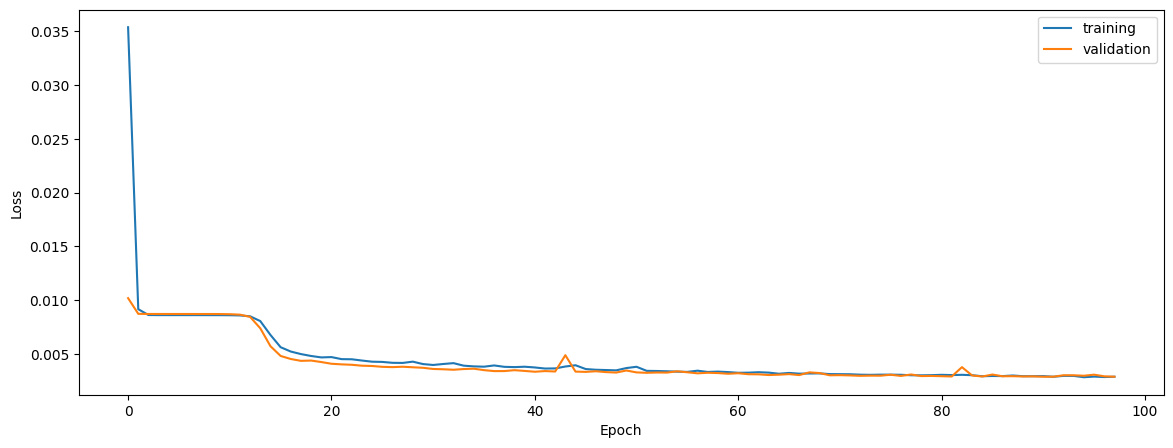

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.818902449058191
0.8180231014122338
0.8190898407203501


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.818902449058191
0.8180231014122338
0.8190898407203501


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8117447361987218
0.8185627953738267
0.8037635540469668


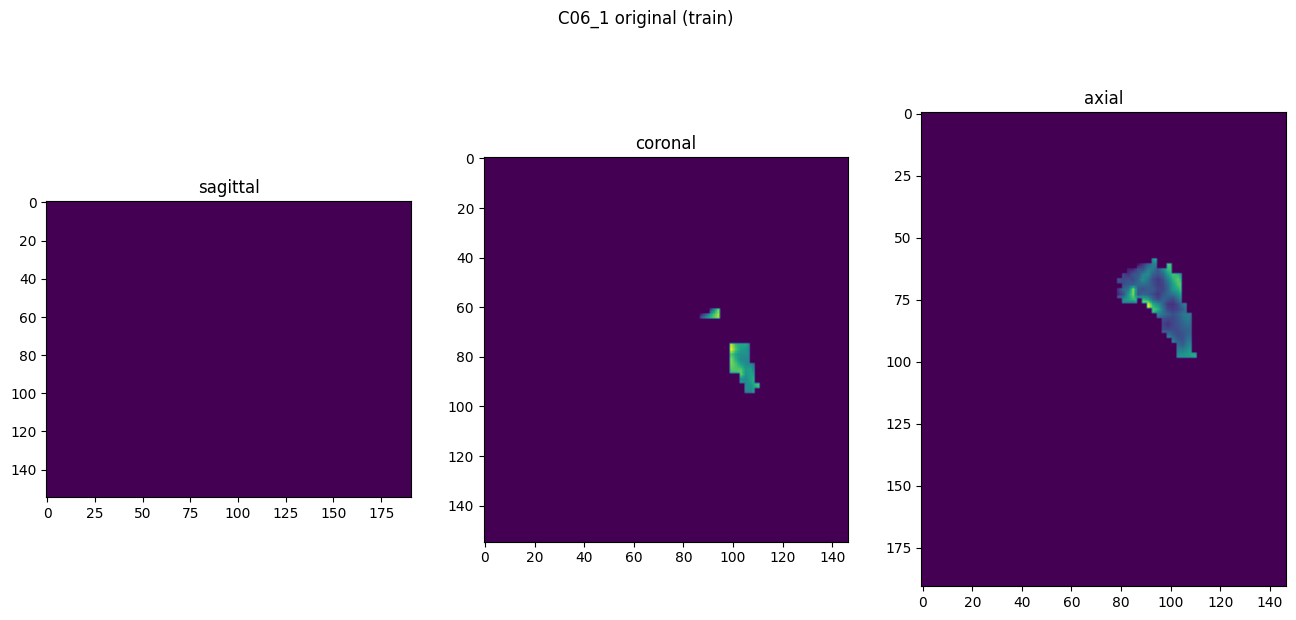

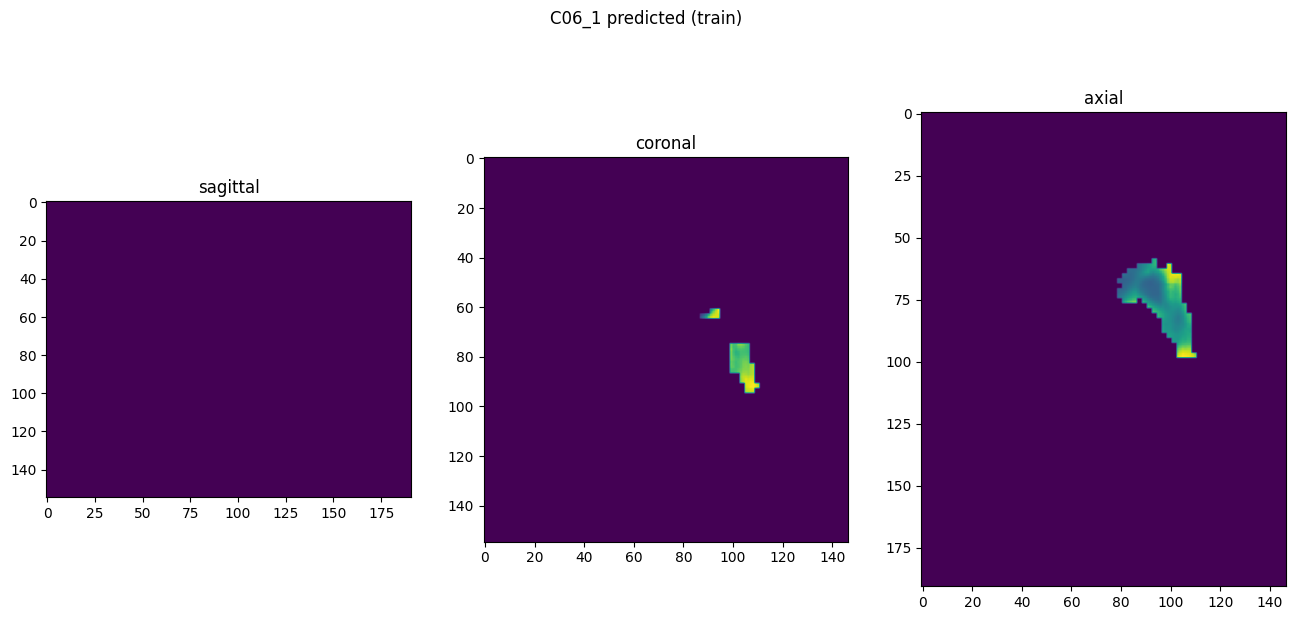

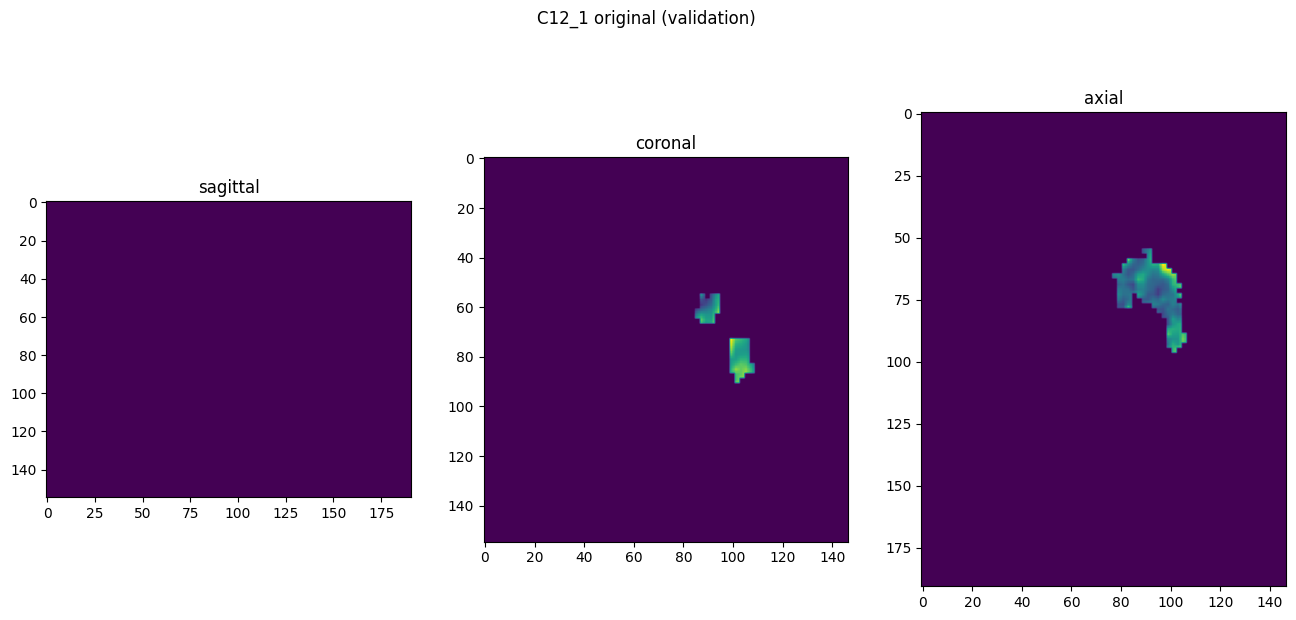

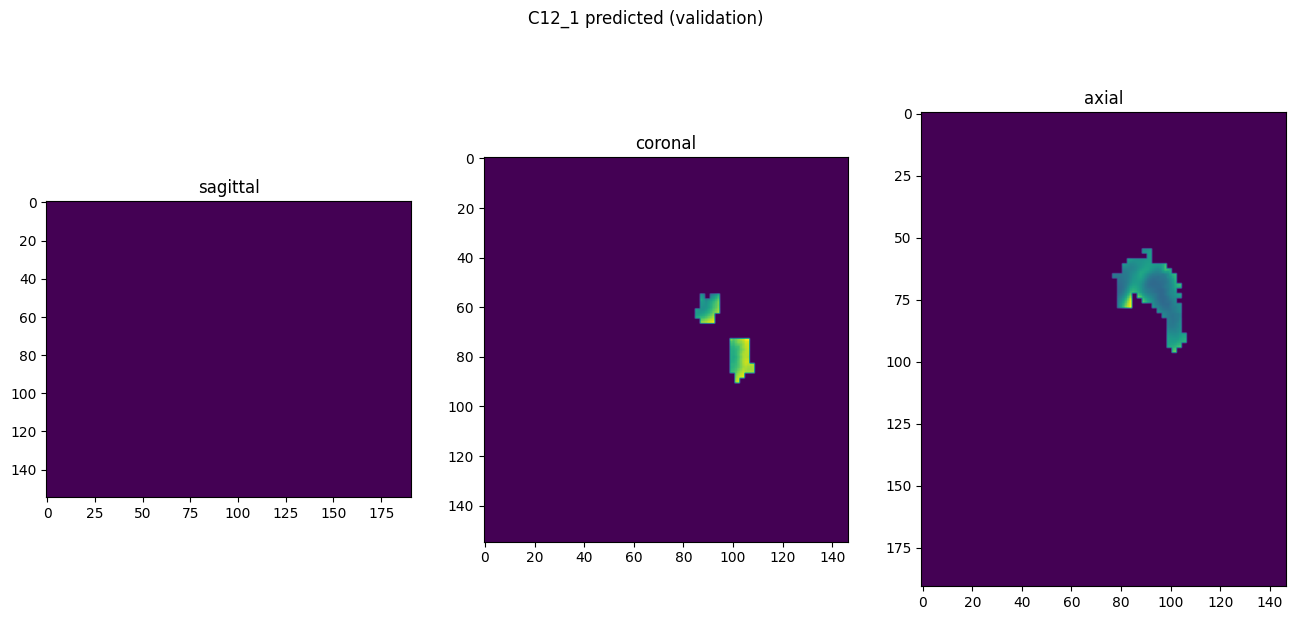

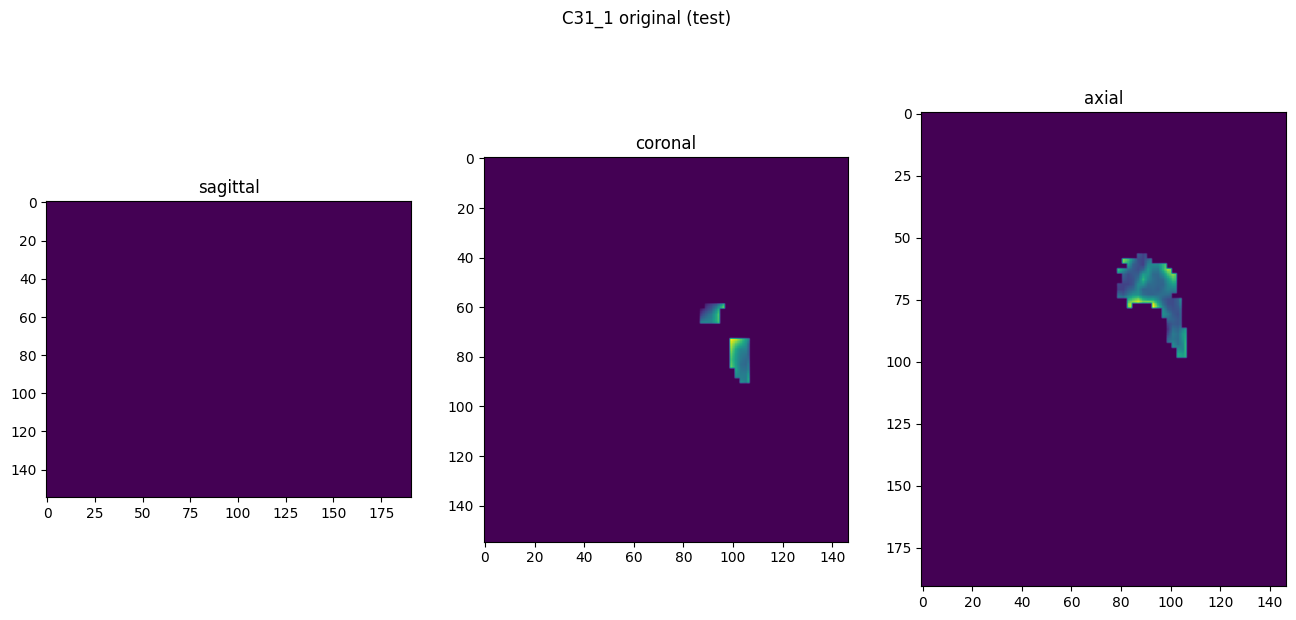

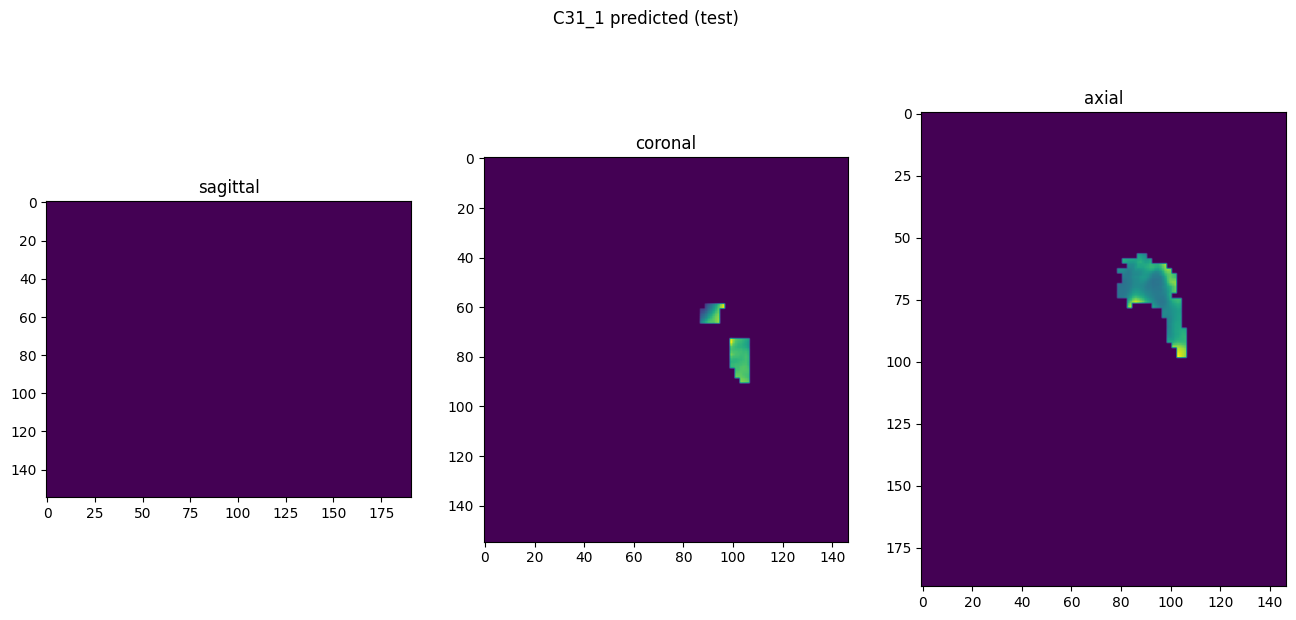

In [10]:
showResults(model, gen, threshold=None, background=False)